In [2]:
%pip install -r requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [40]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # To check if file exists

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import h5py
import math
from tqdm import tqdm  # Use tqdm.notebook for Jupyter
from sklearn.metrics import (precision_recall_fscore_support, roc_auc_score,
                             average_precision_score, confusion_matrix, auc,
                             RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, roc_curve, auc, f1_score)

import gc

In [42]:
def load_sequence_from_h5(h5_path, protein_id):
    """Loads a single sequence string stored as an attribute from the HDF5 file by ID."""
    try:
        with h5py.File(h5_path, 'r') as f:
            if 'embeddings_folder' not in f or protein_id not in f['embeddings_folder']:
                print(f"Warning: Protein ID '{protein_id}' not found in embeddings_folder of {h5_path}")
                return None
            protein_group = f['embeddings_folder'][protein_id]

            # <<< MODIFICATION: Access sequence from attributes >>>
            if 'sequence' in protein_group.attrs:
                sequence_data = protein_group.attrs['sequence']
                # Attributes might already be strings, but handle bytes just in case
                if isinstance(sequence_data, bytes):
                    return sequence_data.decode('utf-8')
                else:
                    return str(sequence_data) # Ensure it's a string
            else:
                print(f"Warning: 'sequence' attribute not found for key '{protein_id}' in {h5_path}")
                return None
            # <<< END MODIFICATION >>>

    except FileNotFoundError:
        print(f"Error: HDF5 file not found at {h5_path}")
        return None
    except Exception as e:
        print(f"Error reading HDF5 file {h5_path} for {protein_id}: {e}")
        return None
def visualize_protein_predictions_standalone(protein_id, sequence, true_labels, predicted_probs, threshold=0.5):
    """Prints sequence visuals and plots probabilities with performance metrics."""
    if sequence is None or not isinstance(sequence, str) or len(sequence) == 0:
        print(f"Cannot visualize {protein_id}: Valid sequence string not provided.")
        return

    # Adjust lengths if slightly different (e.g. off-by-one)
    min_len = min(len(sequence), len(true_labels), len(predicted_probs))
    if not (len(sequence) == len(true_labels) == len(predicted_probs)):
         if abs(len(sequence) - min_len) <= 2 and min_len > 0: # Allow small discrepancy
             print(f"Warning: Length mismatch for {protein_id}. Seq={len(sequence)}, Labels={len(true_labels)}, Probs={len(predicted_probs)}. Truncating to min length {min_len}.")
             sequence = sequence[:min_len]
             true_labels = true_labels[:min_len]
             predicted_probs = predicted_probs[:min_len]
         else:
            print(f"Cannot visualize {protein_id}: Significant length mismatch. Seq={len(sequence)}, Labels={len(true_labels)}, Probs={len(predicted_probs)}.")
            return

    # Calculate performance metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    
    # Binary predictions based on threshold
    predicted_labels = (predicted_probs >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision_val = precision_score(true_labels, predicted_labels, zero_division=0)
    recall_val = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)

    true_sequence_viz = "".join([aa.upper() if label == 1 else aa.lower() for aa, label in zip(sequence, true_labels)])
    predicted_sequence_viz = "".join([aa.upper() if prob >= threshold else aa.lower() for aa, prob in zip(sequence, predicted_probs)])

    print(f"\n--- Visualization for Protein: {protein_id} ---")
    print(f"Length (visualized): {len(sequence)}")
    print(f"Performance Metrics: F1 = {f1:.4f}, Accuracy = {accuracy:.4f}")
    print(f"True Epitopes ({int(sum(true_labels))} residues):")
    for i in range(0, len(sequence), 60): print(true_sequence_viz[i:i+60])
    print(f"\nPredicted Epitopes ({int(sum(predicted_probs >= threshold))} residues @ {threshold} threshold):")
    for i in range(0, len(sequence), 60): print(predicted_sequence_viz[i:i+60])

    # Create a figure with probability plot only
    plt.figure(figsize=(12, 5))
    
    # Plot: Probability plot with true labels
    positions = np.arange(len(sequence))
    plt.plot(positions, predicted_probs, label='Predicted Probability', color='blue', alpha=0.8, linewidth=1.5)
    
    # Add shaded regions for true epitopes
    true_pos_indices = np.where(np.array(true_labels) == 1)[0]
    if len(true_pos_indices) > 0:
        for start, end in get_continuous_regions(true_pos_indices):
            plt.axvspan(start, end, color='red', alpha=0.2)
    
    # Add threshold line
    plt.axhline(y=threshold, color='grey', linestyle='--', label=f'Threshold ({threshold})')
    
    # Annotate metrics on the plot
    metrics_text = (
        f"Metrics @ {threshold} threshold:\n"
        f"Accuracy: {accuracy:.4f}\n"
        f"Precision: {precision_val:.4f}\n"
        f"Recall: {recall_val:.4f}\n"
        f"F1: {f1:.4f}"
    )
    plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.ylim(-0.05, 1.1)
    plt.xlabel('Residue Position')
    plt.ylabel('Predicted Probability')
    plt.title(f'Epitope Prediction for {protein_id}')
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle=':')
    
    plt.tight_layout()
    plt.show()
    print(f"-------------------------------------------------")

def get_continuous_regions(indices):
    """Helper function to identify continuous regions in an array of indices."""
    if len(indices) == 0:
        return []
    
    regions = []
    start = indices[0]
    end = indices[0]
    
    for i in range(1, len(indices)):
        if indices[i] == indices[i-1] + 1:
            end = indices[i]
        else:
            regions.append((start, end))
            start = indices[i]
            end = indices[i]
    
    regions.append((start, end))  # Add the last region
    return regions


In [43]:
embedding_type = 'esm2'

In [44]:
H5_TEST_PATH = f'{embedding_type}_test_protein_embeddings.h5'
JSON_PATH = {'mlp': {'esm2': "final_training/mlp/esm2/esm2_MLP_final_training_04-18_1527/esm2_best_f1/esm2_final_training_summary.json",
                     'esmc': "final_training/mlp/esmc/esmc_MLP_final_training_04-18_1222/esmc_best_f1/esmc_final_training_summary.json"},
            'transformer': {'esm2': "final_training/transformer/esm2/esm2_best_model_results.json",
                           'esmc': "final_training/transformer/esmc/esmc_best_model_results.json"},
            'xgboost': {'esm2': "final_training/xgboost/esm2/esm2_xgb_final_results_summary.json",
                        'esmc': "final_training/xgboost/esmc/esmc_xgb_final_results_summary.json"}}

BEST_MODEL_PATH = {'mlp': {'esm2': "final_training/mlp/esm2/esm2_MLP_final_training_04-18_1527/esm2_best_f1/esm2_mlp_final_best.pth",
                     'esmc': "final_training/mlp/esmc/esmc_MLP_final_training_04-18_1222/esmc_best_f1/esmc_mlp_final_best.pth"},
            'transformer': {'esm2': "final_training/transformer/esm2/saved models/esm2_FINAL_BEST_MODEL.pth",
                           'esmc': "final_training/transformer/esmc/esmc_FINAL_BEST_MODEL.pth"},
            'xgboost': {'esm2': "final_training/xgboost/esm2/esm2_xgb_final_model.json",
                        'esmc': "final_training/xgboost/esmc/esmc_xgb_final_model.json"}}

# Analysis of Random Search JSON File

In [4]:
path_to_run_json = '/work/jgg/exp1137-improving-b-cell-antigen-predictions-using-plms/esmc_transformer_runs_20250411_085250/esmc/esmc_hyperparam_search_results.json'
with open(path_to_run_json, 'r') as f:
    data = json.load(f)

In [17]:
def load_results(filepath):
    """Loads the hyperparameter search results from a JSON file."""
    if not os.path.exists(filepath):
        print(f"Error: File not found at '{filepath}'")
        return None
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
        if not isinstance(data, list):
            print(f"Error: Expected a list of trials in '{filepath}', but got {type(data)}")
            return None
        print(f"Successfully loaded {len(data)} trial results from '{filepath}'")
        return data
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from '{filepath}': {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading '{filepath}': {e}")
        return None

def preprocess_results(results_list):
    """Flattens the results list and prepares it for DataFrame creation."""
    processed_data = []
    if not results_list:
        return processed_data

    for trial in results_list:
        # Ensure basic structure exists
        if not isinstance(trial, dict) or 'trial_num' not in trial:
            print(f"Warning: Skipping invalid trial entry: {trial}")
            continue

        flat_trial = {'trial_num': trial.get('trial_num')}

        # Flatten parameters
        params = trial.get('params', {})
        if isinstance(params, dict):
            for key, value in params.items():
                flat_trial[f'param_{key}'] = value
        else:
            print(f"Warning: Invalid 'params' structure in trial {flat_trial['trial_num']}")

        # Flatten average metrics
        avg_metrics = trial.get('avg_metrics', {})
        if isinstance(avg_metrics, dict):
             for key, value in avg_metrics.items():
                flat_trial[f'metric_{key}'] = value
        else:
             # Handle cases where avg_metrics might be missing or empty if a trial failed early
             flat_trial[f'metric_{PRIMARY_METRIC}'] = np.nan # Ensure primary metric exists for sorting

        # Flatten standard deviation metrics
        std_metrics = trial.get('std_metrics', {})
        if isinstance(std_metrics, dict):
             for key, value in std_metrics.items():
                flat_trial[f'stdev_{key}'] = value

        # Add status and best epoch info (average across folds if available)
        flat_trial['status'] = trial.get('status', 'unknown')
        individual_folds = trial.get('individual_fold_metrics', [])
        if isinstance(individual_folds, list) and individual_folds:
            # Ensure fold data is valid before trying to access 'epoch'
            epochs = [fold.get('epoch') for fold in individual_folds if isinstance(fold, dict) and 'epoch' in fold and fold.get('epoch') is not None]
            if epochs:
                flat_trial['avg_best_epoch'] = np.mean(epochs)
                flat_trial['std_best_epoch'] = np.std(epochs)
            else:
                 flat_trial['avg_best_epoch'] = np.nan
                 flat_trial['std_best_epoch'] = np.nan
        else:
            flat_trial['avg_best_epoch'] = np.nan
            flat_trial['std_best_epoch'] = np.nan

        processed_data.append(flat_trial)

    return processed_data

def find_best_trial(df, metric):
    """Finds the trial with the best score based on the specified metric."""
    metric_col = f'metric_{metric}'
    if metric_col not in df.columns:
        print(f"Error: Metric column '{metric_col}' not found in DataFrame.")
        return None

    # Filter out failed trials or trials where the metric wasn't calculated
    valid_df = df[df['status'] == 'completed'].dropna(subset=[metric_col])

    if valid_df.empty:
        print(f"No completed trials found with valid '{metric_col}' scores.")
        return None
    # Use idxmax() to get the index of the maximum value
    best_trial_index = valid_df[metric_col].idxmax()
    # Retrieve the corresponding row using .loc
    best_trial_row = valid_df.loc[best_trial_index]
    return best_trial_row

In [18]:
data = load_results(path_to_run_json)

Successfully loaded 20 trial results from '/work/jgg/exp1137-improving-b-cell-antigen-predictions-using-plms/esmc_transformer_runs_20250411_085250/esmc/esmc_hyperparam_search_results.json'


In [29]:
processed_list = preprocess_results(data)
PRIMARY_METRIC = 'auc_pr'
results_df = pd.DataFrame(processed_list).sort_values('metric_auc_pr', ascending=False)
results_df

# TRANSFORMER BLOCK

In [45]:
model_type = 'transformer'
H5_TEST_PATH
JSON_SELECTED = JSON_PATH[model_type][embedding_type]
SELECTED_BEST_MODEL = BEST_MODEL_PATH[model_type][embedding_type]

print(H5_TEST_PATH, JSON_SELECTED, SELECTED_BEST_MODEL)

esm2_test_protein_embeddings.h5 final_training/transformer/esm2/esm2_best_model_results.json final_training/transformer/esm2/saved models/esm2_FINAL_BEST_MODEL.pth


## Model functions

In [46]:
class Embedding_retriever(Dataset): 
    def __init__(self, h5_path, protein_keys = None):
        self.h5_path = h5_path
        with h5py.File(self.h5_path, 'r') as f:
            all_keys = list(f['embeddings_folder'].keys())
            all_keys.sort()
            self.protein_keys = protein_keys if protein_keys is not None else all_keys

    def __len__(self): 
        return len(self.protein_keys) 

    def __getitem__(self, index): 
        protein_key = self.protein_keys[index]
        with h5py.File(self.h5_path, 'r') as f:
            protein_group = f['embeddings_folder'][protein_key]
            embeddings = protein_group['embeddings'][:]
            labels = protein_group['labels'][:]
            labels = labels.astype(np.float32) 

        return {
            'name': protein_key,
            'embeddings': torch.tensor(embeddings, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.float32),
            'length': len(labels) 
        }


### Padding Collate Function
def collate_fn(batch):
    embeddings = [item['embeddings'] for item in batch]
    labels = [item['labels'] for item in batch]
    lengths = [item['length'] for item in batch]
    names = [item['name'] for item in batch]

    padded_embeddings = nn.utils.rnn.pad_sequence(embeddings, batch_first=True, padding_value= 0.0)
    padded_labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-1)

    max_len = padded_embeddings.size(1)
    lengths_tensor = torch.tensor(lengths, dtype=torch.long)
    padding_mask  =torch.arange(max_len)[None, :] >= lengths_tensor[:, None]

    return {
        'names': names,
        'embeddings': padded_embeddings,
        'labels': padded_labels,
        'padding_mask': padding_mask,
        'lengths': lengths_tensor
    }

# Building Our Models

## Transformer Model
MAX_LEN = 5000

# --- Positional Encoding --- 
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len = MAX_LEN):
        super().__init__()
            #super(PositionalEncoder, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model) #generating empty tensor to later populate with positional encoding values.
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # Create a column vector of token positions, which will later be used to calculate sinusoidal encodings 
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # the denominator of PE formula.

        #Slicing of both even and uneven terms (removed if/else function)
        pe[:, 0::2] = torch.sin(position * div_term) # generators tensor using sine function
        pe[:, 1::2] = torch.cos(position * div_term) # generators tensor using sine function

        self.register_buffer('pe', pe) # fixed paramter, not trainable.

    def forward(self, x):
        # apply positional encoding to input.
        pos_encoding_slice = self.pe[:x.size(1), :].unsqueeze(0)
        x = x + pos_encoding_slice
        return self.dropout(x) # regularization to input
    
        # OBS!!!: dimension output of PE is now [batch_size, seq_len, embed_dim]´

# --- SiLu (Swish) Feed Forward Network ---
class SiLuFFN(nn.Module):
    def __init__(self, embed_dim, ffn_hidden_dim, dropout=0.1):
        super().__init__()

        self.w1 = nn.Linear(embed_dim, ffn_hidden_dim, bias=True) # defines 1st layer
        self.w2 = nn.Linear(ffn_hidden_dim, embed_dim, bias=True) # defines 2nd layer
        self.dropout = nn.Dropout(dropout) # a good ol' dropout layer
        self.activation = F.silu # stores SWISH activation function

    def forward(self ,x):
        hidden = self.w1(x) #passing input through first (w1) layer    
        activated = self.activation(hidden) # applying SWISH    
        dropped = self.dropout(activated) # applying dropout
        output = self.w2(dropped) # pass through second (w2) layer

        return output # returns final processed tensors

# --- Transformer Encoder Layer with SiLU FFN ---
class TransformerEncoderLayer(nn.Module):                       # (vi kan måske fjerne lidt kommentarer)
    def __init__(self, embed_dim, nhead, ffn_hidden_dim, dropout=0.1, pre_norm=True):
        super().__init__()
        self.pre_norm = pre_norm

        #Sub layers
        self.self_attn = nn.MultiheadAttention(embed_dim, nhead, dropout=dropout, batch_first=True) # 1. MHA
        self.ffn = SiLuFFN(embed_dim, ffn_hidden_dim, dropout) # FFN part of transformer block.T_destination

        # Layer norm & dropout
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim) # will have different weights
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout) # will have different weights

    def forward(self, src, src_mask=None, src_key_padding_mask=None): # (gammel)
        if self.pre_norm:
            # Pre-LN: Norm -> Sublayer -> Dropout -> Residual
            # 1. Multi-Head Attention block
            src_norm1 = self.norm1(src) # normalize first (PRE)
            attention_output, _ = self.self_attn(src_norm1, src_norm1, src_norm1, # these are for the Q, K and V tensors
                                                 attn_mask=src_mask,
                                                 key_padding_mask=src_key_padding_mask,
                                                 need_weights=False)
            src = src + self.dropout1(attention_output) # We dropout some of our output from the attention layer

            # 2. Feed-Forward block
            src_norm2 = self.norm2(src) # again, normalize first (from prev block output)
            ffn_output = self.ffn(src_norm2)
            src = src + self.dropout2(ffn_output) # We dropout some of our output from the FFN layer (residual connection)
        
            return src # this output goes to decoder block
        
        else: 
            # Post-LN: Sublayer -> Dropout -> Residual -> Norm
            attention_output, _ = self.self_attn(src, src, src, # these are for the Q, K and V tensors
                                             attn_mask=src_mask,
                                             key_padding_mask=src_key_padding_mask,
                                             need_weights=False)
        
            # Add & Norm (Residual Connection 1) 
            src = src + self.dropout1(attention_output) # We dropout some of our output from the attention layer
            src = self.norm1(src) # and we apply layer normalization

            # FF block
            ffn_output = self.ffn(src)

            # Add & Norm (Residual Connection 2) 
            src = src + self.dropout2(ffn_output) # We dropout some of our output from the FFN layer
            src = self.norm2(src) # and we apply layer normalization

            return src # this output goes to decoder block
            

# --- Main Epitope Transformer Model using SiLU ---
class EpitopeTransformer(nn.Module):
    def __init__(self, embed_dim, nhead, num_encoder_layers, ffn_hidden_dim,
                 dropout=0.1, max_len=MAX_LEN, pre_norm=True, use_seq_length = True):
        
        super().__init__()
        self.embed_dim = embed_dim
        self.pre_norm = pre_norm
        self.use_seq_length = use_seq_length

        self.pos_encoder = PositionalEncoder(embed_dim, dropout, max_len) # first PE layer

        # Encoder Stack
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, nhead, ffn_hidden_dim, dropout, pre_norm=self.pre_norm)
            for _ in range(num_encoder_layers)
        ])

        self.norm_final = nn.LayerNorm(embed_dim) if self.pre_norm else nn.Identity()  # if pre-ln: need one final norm after stack.
        
        if self.use_seq_length:
            self.output_layer = nn.Linear(embed_dim + 1, 1) # transformed to 1 dimension and adding sequence lenght
        else:
            self.output_layer = nn.Linear(embed_dim , 1) # transformed to 1 dimension
        self.init_weights() # optional, but good practice

    def init_weights(self):
        initrange = 0.1
        nn.init.zeros_(self.output_layer.bias)
        nn.init.uniform_(self.output_layer.weight, -initrange, initrange) # initialize bias with zeros, weights with uniform

    def forward(self, src, src_key_padding_mask=None, seq_lengths = None): #padding mask=None as we're only in encoder layer
        src = self.pos_encoder(src) # we encode input. Shape: [B, SeqLen, EmbDim] 

        output = src # we initialize output value and loop through each encoder layer passing the output from layer to layer.
        for layer in self.layers:
            output = layer(output, src_key_padding_mask=src_key_padding_mask)
        output = self.norm_final(output) # apply final norm if only Pre-LN is used

        if self.use_seq_length and seq_lengths is not None:
            # Normalize sequence lengths to [0,1] range
            batch_size, seq_len, _ = output.shape
            norm_seq_lengths = seq_lengths.float() / MAX_LEN
            
            # Expand sequence length to match output dimensions
            # Shape: [batch_size, 1, 1] -> [batch_size, seq_len, 1]
            expanded_seq_lengths = norm_seq_lengths.view(batch_size, 1, 1).expand(batch_size, seq_len, 1)
            
            # Concatenate expanded sequence lengths with transformer output
            # Shape: [batch_size, seq_len, embed_dim + 1]
            output_with_len = torch.cat([output, expanded_seq_lengths], dim=2)
            
            # Apply the final output layer
            output_logits = self.output_layer(output_with_len)
        else:
            output_logits = self.output_layer(output)
        # Output shape: [batch_size, seq_len, 1]
        
        return output_logits
    

## Setup

In [47]:
#Hyperparameter config
path_to_json = JSON_SELECTED


EMBED_DIM = 960 if 'esmc' in path_to_json.lower() else 1280
with open(path_to_json, 'r') as f:
    data = json.load(f)

LEARNING_RATE = data['hyperparameters']['learning_rate']
DROPOUT = data['hyperparameters']['dropout']
N_HEAD = data['hyperparameters']['nhead']
NUM_ENCODER_LAYERS = data['hyperparameters']['num_encoder_layers']
FFN_HIDDEN_DIM_FACTOR = data['hyperparameters']['ffn_hidden_dim_factor']
FFN_HIDDEN_DIM = FFN_HIDDEN_DIM_FACTOR*EMBED_DIM
PRE_NORM = True

PATH_TO_BEST_MODEL = SELECTED_BEST_MODEL


if torch.cuda.is_available():
    device_str = "cuda"
    print("CUDA is available. Using GPU.")
else:
    device_str = "cpu"
    print("CUDA not available. Using CPU.")
DEVICE = torch.device(device_str)

CUDA is available. Using GPU.


In [48]:
print("Initializing model architecture...")
# Instantiate the model with the training hyperparameters
model = EpitopeTransformer(
    embed_dim=EMBED_DIM,
    nhead=N_HEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    ffn_hidden_dim=FFN_HIDDEN_DIM,
    dropout=DROPOUT, 
    pre_norm=PRE_NORM,
    max_len=MAX_LEN 
).to(DEVICE)

print(f"Loading model state dictionary from: {PATH_TO_BEST_MODEL}")
try:
    checkpoint = torch.load(PATH_TO_BEST_MODEL, map_location=DEVICE)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
except FileNotFoundError:
    print(f"ERROR: Model file not found at {PATH_TO_BEST_MODEL}")
    # Optionally exit or handle error
    raise
except Exception as e:
    print(f"ERROR loading model weights: {e}")
    # Might indicate architecture mismatch or corrupted file
    raise

# Set the model to evaluation mode
# This disables dropout and batch normalization updates
model.eval()
print("Model set to evaluation mode.")

Initializing model architecture...
Loading model state dictionary from: final_training/transformer/esm2/saved models/esm2_FINAL_BEST_MODEL.pth
Model set to evaluation mode.


In [49]:
# Print model summary
print("\n--- Model Architecture ---")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("-------------------------")


--- Model Architecture ---
EpitopeTransformer(
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.15032412462017214, inplace=False)
  )
  (layers): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
      )
      (ffn): SiLuFFN(
        (w1): Linear(in_features=1280, out_features=3840, bias=True)
        (w2): Linear(in_features=3840, out_features=1280, bias=True)
        (dropout): Dropout(p=0.15032412462017214, inplace=False)
      )
      (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.15032412462017214, inplace=False)
      (dropout2): Dropout(p=0.15032412462017214, inplace=False)
    )
  )
  (norm_final): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (output_layer): Linear(in_features=1281, out_features=1,

## Evaluation on Test Set

In [50]:
# %%
print(f"\nPreparing test dataset from: {H5_TEST_PATH}")
try:
    test_dataset = Embedding_retriever(H5_TEST_PATH)
    print(f"Test dataset loaded with {len(test_dataset)} proteins.")

    test_loader = DataLoader(
        test_dataset,
        batch_size=8, # Use desired batch size for evaluation
        shuffle=False,         # No need to shuffle for testing
        collate_fn=collate_fn,
        num_workers=2,         # Adjust based on your system
        pin_memory=(DEVICE.type == 'cuda') # Use pin_memory if on GPU
    )
    print("Test DataLoader created.")
except Exception as e:
    print(f"Failed to create test dataset/loader: {e}")
    # Handle error appropriately
    raise


Preparing test dataset from: esm2_test_protein_embeddings.h5
Test dataset loaded with 15 proteins.
Test DataLoader created.


In [51]:
from tqdm import tqdm
print("\nStarting evaluation on the test set...")

all_test_preds_prob = []
all_test_labels_list = []
protein_results = {} # Optional: Store per-protein results

with torch.no_grad(): # Disable gradient calculations for inference
    pbar = tqdm(test_loader, desc="Evaluating Test Set")
    for batch in pbar:
        if batch is None:
            print("Warning: Skipping None batch from collate_fn.")
            continue

        # Move data to the configured device
        embeddings = batch['embeddings'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        padding_mask = batch['padding_mask'].to(DEVICE) # True for padded positions
        names = batch['names']
        lengths = batch['lengths'].to(DEVICE)  # Make sure lengths are on the correct device

        outputs = model(
            embeddings, 
            src_key_padding_mask=padding_mask,
            seq_lengths = lengths
        ).squeeze(-1)  # Shape: [B, SeqLen]

        active_mask = (labels != -1) # Shape: [B, SeqLen], True for non-padded

        # Iterate through batch items if needed for per-protein results
        for i in range(outputs.shape[0]): # Iterate through proteins in the batch
            seq_len = lengths[i].item() # Actual length of this sequence
            protein_name = names[i]

            valid_outputs_mask = active_mask[i, :seq_len] # Mask within the actual length
            protein_logits = outputs[i, :seq_len][valid_outputs_mask]
            protein_labels = labels[i, :seq_len][valid_outputs_mask]

            if protein_labels.numel() > 0: # Ensure there are valid residues
                 # Check for NaNs/Infs before sigmoid
                if torch.isnan(protein_logits).any() or torch.isinf(protein_logits).any():
                    print(f"Warning: NaN/Inf logits detected for {protein_name}. Skipping sequence metrics.")
                    continue

                protein_probs = torch.sigmoid(protein_logits).cpu().numpy()
                protein_labels_np = protein_labels.cpu().numpy()
                # Convert probabilities to binary predictions using threshold 0.5
                protein_preds = (protein_probs >= 0.5).astype(int)

                all_test_preds_prob.extend(protein_probs)
                all_test_labels_list.extend(protein_labels_np)
                
                # Calculate F1 score for this protein
                try:
                    protein_precision, protein_recall, protein_f1, _ = precision_recall_fscore_support(
                        protein_labels_np, 
                        protein_preds,
                        average='binary', 
                        zero_division=0
                    )
                except:
                    protein_f1 = 0.0  # Default if calculation fails

                protein_results[protein_name] = {
                     'labels': protein_labels_np,
                     'probabilities': protein_probs,
                     'auc_pr': average_precision_score(protein_labels_np, protein_probs) if len(np.unique(protein_labels_np)) > 1 else 0.0,
                     'f1': protein_f1 
                 }

del embeddings, labels, padding_mask, outputs
gc.collect()
if DEVICE.type == 'cuda':
    torch.cuda.empty_cache()

print("Evaluation loop finished.")
transformer_stuff = protein_results


Starting evaluation on the test set...


Evaluating Test Set: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Evaluation loop finished.



--- Test Set Performance ---
  AUC-PR: 0.3408
  AUC-ROC: 0.7175
  AUC10 (max_fpr=0.1): 0.5482
  F1-Score: 0.4248
  Precision: 0.3243
  Recall: 0.6154

  Confusion Matrix (Rows: Actual, Cols: Predicted @ 0.5 Threshold):
        Predicted 0    Predicted 1
Actual 0 | 1513         | 650          | (TN=1513, FP=650)
Actual 1 | 195          | 312          | (FN=195, TP=312)
--------------------------------------------------------------------


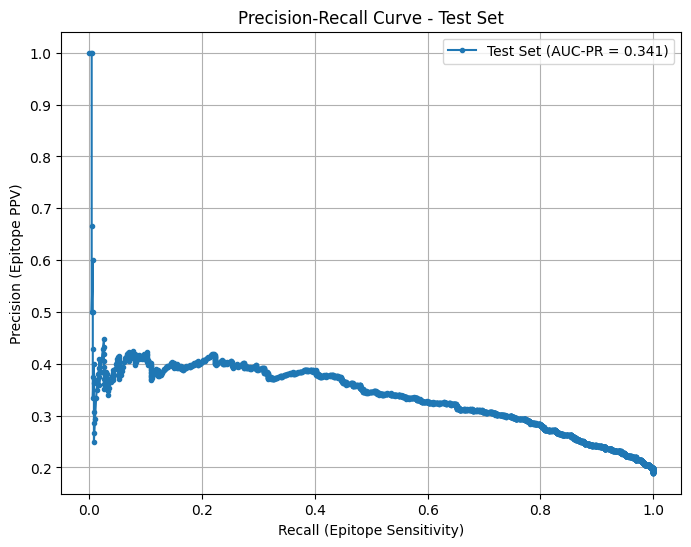

In [52]:
print("\n--- Test Set Performance ---")

if not all_test_labels_list:
    print("No valid labels/predictions collected from the test set. Cannot calculate metrics.")
else:
    # Convert collected lists to numpy arrays
    all_test_labels_np = np.array(all_test_labels_list).astype(int)
    all_test_preds_prob_np = np.array(all_test_preds_prob)

    # --- Calculate Metrics ---
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        all_test_labels_np,
        (all_test_preds_prob_np >= 0.5).astype(int), # Use 0.5 threshold for these metrics
        average='binary',
        zero_division=0
    )

    # Calculate AUCs carefully, handling potential errors/edge cases
    test_auc_roc = 0.0
    test_auc10 = 0.0
    test_auc_pr = 0.0

    unique_labels_test = np.unique(all_test_labels_np)
    if len(unique_labels_test) < 2:
        print(f"Warning: Only one class ({unique_labels_test}) present in test labels. AUC-ROC/AUC10 set to 0.0.")
        try:
             # AUC-PR might be 1.0 if only positive class, 0.0/NaN otherwise
             test_auc_pr = average_precision_score(all_test_labels_np, all_test_preds_prob_np)
             if np.isnan(test_auc_pr): test_auc_pr = 0.0
        except ValueError: test_auc_pr = 0.0
    else: # Both classes present
        try:
            test_auc_pr = average_precision_score(all_test_labels_np, all_test_preds_prob_np)
        except ValueError as e:
            print(f"Warning: Test AUC-PR calculation error: {e}")
        try:
            test_auc_roc = roc_auc_score(all_test_labels_np, all_test_preds_prob_np)
            try:
                if len(all_test_labels_np) > 10:
                     test_auc10 = roc_auc_score(all_test_labels_np, all_test_preds_prob_np, max_fpr=0.1)
                else: print("Warning: Low sample count for AUC10.")
            except ValueError: print("Warning: AUC10 calculation failed.")
        except ValueError as e:
            print(f"Warning: Test AUC-ROC calculation error: {e}")

    # Calculate Confusion Matrix
    try:
        test_cm = confusion_matrix(
            all_test_labels_np,
            (all_test_preds_prob_np >= 0.5).astype(int),
            labels=[0, 1] # Ensure consistent order
        )
    except ValueError as e:
        print(f"Warning: Could not compute confusion matrix: {e}")
        test_cm = np.zeros((2, 2), dtype=int) # Default to zeros

    # --- Print Metrics ---
    print(f"  AUC-PR: {test_auc_pr:.4f}")
    print(f"  AUC-ROC: {test_auc_roc:.4f}")
    print(f"  AUC10 (max_fpr=0.1): {test_auc10:.4f}")
    print(f"  F1-Score: {test_f1:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall: {test_recall:.4f}")

    print("\n  Confusion Matrix (Rows: Actual, Cols: Predicted @ 0.5 Threshold):")
    print(f"        Predicted 0    Predicted 1")
    print(f"Actual 0 | {test_cm[0, 0]:<12} | {test_cm[0, 1]:<12} | (TN={test_cm[0, 0]}, FP={test_cm[0, 1]})")
    print(f"Actual 1 | {test_cm[1, 0]:<12} | {test_cm[1, 1]:<12} | (FN={test_cm[1, 0]}, TP={test_cm[1, 1]})")
    print(f"--------------------------------------------------------------------")

    # Optional: Plot PR Curve
    precision_curve, recall_curve, _ = precision_recall_curve(all_test_labels_np, all_test_preds_prob_np)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, marker='.', label=f'Test Set (AUC-PR = {test_auc_pr:.3f})')
    plt.xlabel('Recall (Epitope Sensitivity)')
    plt.ylabel('Precision (Epitope PPV)')
    plt.title('Precision-Recall Curve - Test Set')
    plt.grid(True)
    plt.legend()
    plt.show()

## Best and Worst

In [53]:
if protein_results:
    print("\n--- Per-Protein AUC-PR (Example) ---")
    # Sort proteins by AUC-PR (descending)
    sorted_proteins = sorted(protein_results.items(), key=lambda item: item[1]['f1'], reverse=True)
    for i, (name, results) in enumerate(sorted_proteins):
         print(f"{name}: F1 = {results['f1']:.4f}")
         if i >= 20: # Show top 10
              print("...")
              break
    print("-------------------------------------")


--- Per-Protein AUC-PR (Example) ---
4ypg_D: F1 = 0.5592
3pnw_O: F1 = 0.5479
7chz_I: F1 = 0.5000
6vtw_A: F1 = 0.4839
7jum_A: F1 = 0.4783
7lj4_B: F1 = 0.4660
6y6c_A: F1 = 0.4314
4qci_D: F1 = 0.4156
4xak_A: F1 = 0.4111
6u6u_R: F1 = 0.3368
5th9_A: F1 = 0.2778
2xwt_C: F1 = 0.2687
5d8j_A: F1 = 0.2182
5f72_K: F1 = 0.1481
6hga_B: F1 = 0.0000
-------------------------------------


## Grafer


Generating visualizations for: ['4qci_D', '6hga_B']

--- Visualization for Protein: 4qci_D ---
Length (visualized): 96
Performance Metrics: F1 = 0.4156, Accuracy = 0.5312
True Epitopes (18 residues):
iaepamiaecktrtevfeisrrlidrtnanfLVWppcvevqrcsgccNnRnvqcrptqvq
lrpvQvRkIEIvRKKPIFKKatvtledhlackcetv

Predicted Epitopes (59 residues @ 0.5 threshold):
IaEPaMiaEcKtRTevfEiSRRliDRTNANflvWpPcvEvQRCSgccNNRNVQcRPTQvQ
LRPvQvRKIEIVRKKPIFKKatvtledhlAcKcETV


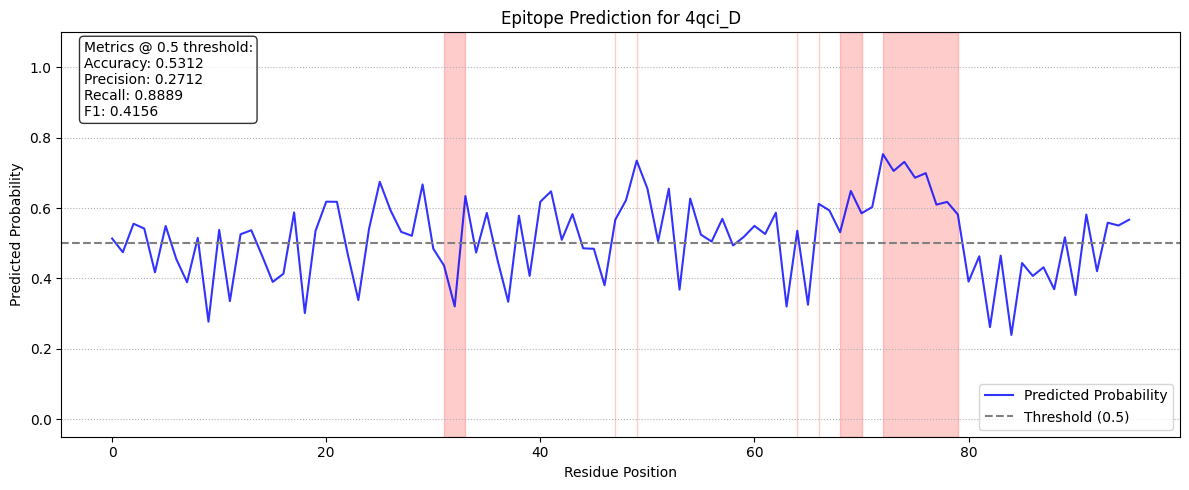

-------------------------------------------------

--- Visualization for Protein: 6hga_B ---
Length (visualized): 263
Performance Metrics: F1 = 0.0000, Accuracy = 0.8859
True Epitopes (12 residues):
lpwlnvsadgdnvhlvlnvseeqhfglslywnqvqgppkprwhknltgpqiitlqhtdlv
pclciqvwplepdsvrtnicpfredprahqnlwqaarlrlltlqswlldapcslpaeaal
cwrapggdpcqplvpplsweqvtvdkvlefpllkghpnlcvqvqsseklqlqeclwadsl
gplkddvllletrgpqdqrslcalepsgctslpsKaStraaRLgEYllqdlqsgqclqlw
dddlgalwacpmdkyihKREFRH

Predicted Epitopes (18 residues @ 0.5 threshold):
lpwlnvsadgdnvhlvlnvseeqhfglslywnqvQgppkprwhknltgpqiitlqhtdlv
pclciqvwpLEPdsvRtnicpfredprahqnlwqaarlrlltlqswlldapcslPaeaal
cwraPggdpcqplvpplsWEQvTvDKvlefpllkghpnlcvqvqssEklqlqeclwadsl
gplkddvllletrgpqdqrslcalePSgctslpskastraarlgeyllqdlqsgqclqlw
dDDlgalwacpmdkyihkrefrh


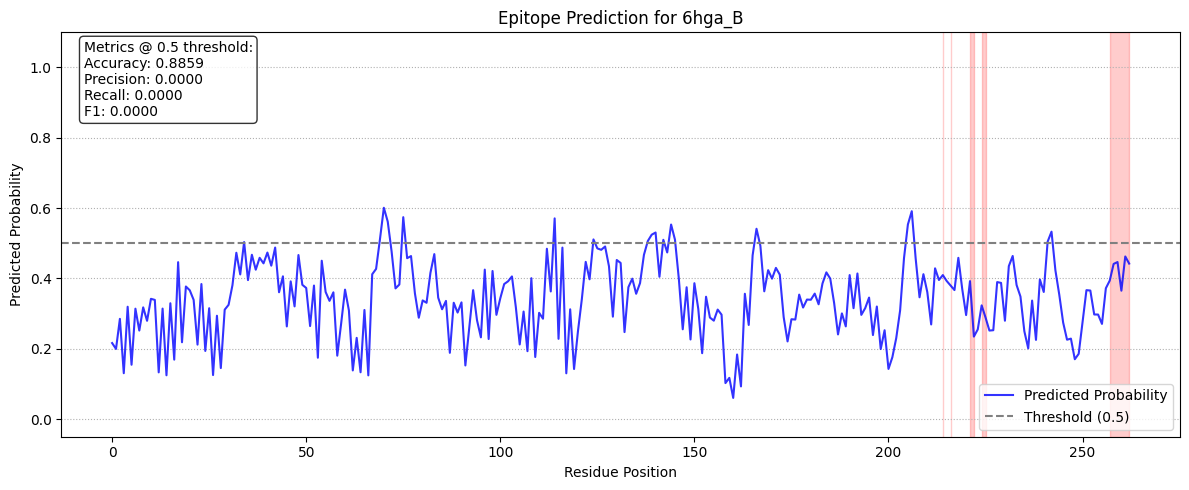

-------------------------------------------------


In [54]:
if 'protein_results' in locals() and isinstance(protein_results, dict):
    VISUALIZATION_THRESHOLD = 0.5
    
    # Best and worst performers based on your data
    PROTEINS_TO_VISUALIZE = ['4qci_D', '6hga_B']  # Best and worst 
    
    if not PROTEINS_TO_VISUALIZE:
         print("No proteins selected for visualization.")
    else:
        print(f"\nGenerating visualizations for: {PROTEINS_TO_VISUALIZE}")
        # Ensure H5_TEST_PATH is defined from previous cells
        if 'H5_TEST_PATH' not in locals() or not H5_TEST_PATH:
             print("Error: H5_TEST_PATH variable not defined. Cannot load sequences.")
        else:
            for protein_id in PROTEINS_TO_VISUALIZE:
                if protein_id in protein_results:
                    sequence = load_sequence_from_h5(H5_TEST_PATH, protein_id)
                    true_labels = protein_results[protein_id]['labels']
                    predicted_probs = protein_results[protein_id]['probabilities']
                    visualize_protein_predictions_standalone(
                        protein_id, sequence, true_labels, predicted_probs, threshold=VISUALIZATION_THRESHOLD
                    )
                else:
                    print(f"Protein ID '{protein_id}' not found in collected results.")
else:
    print("Variable 'protein_results' not found or is not a dictionary. Make sure the evaluation cell ran successfully.")

# MLP

In [55]:
model_type = 'mlp'
H5_TEST_PATH
JSON_SELECTED = JSON_PATH[model_type][embedding_type]
SELECTED_BEST_MODEL = BEST_MODEL_PATH[model_type][embedding_type]

print(H5_TEST_PATH, JSON_SELECTED, SELECTED_BEST_MODEL)

esm2_test_protein_embeddings.h5 final_training/mlp/esm2/esm2_MLP_final_training_04-18_1527/esm2_best_f1/esm2_final_training_summary.json final_training/mlp/esm2/esm2_MLP_final_training_04-18_1527/esm2_best_f1/esm2_mlp_final_best.pth


## Model functions

In [56]:
# --- Dataset Class (Unchanged) ---
class Embedding_retriever(Dataset):
    def __init__(self, h5_path, protein_keys = None):
        self.h5_path = h5_path
        with h5py.File(self.h5_path, 'r') as f:
            all_keys = list(f['embeddings_folder'].keys())
            all_keys.sort()
            # Ensure protein_keys is None or a list/tuple
            if protein_keys is not None and not isinstance(protein_keys, (list, tuple, np.ndarray)):
                 raise TypeError("protein_keys must be a list, tuple, numpy array, or None")
            self.protein_keys = list(protein_keys) if protein_keys is not None else all_keys


    def __len__(self):
        return len(self.protein_keys)

    def __getitem__(self, index):
        protein_key = self.protein_keys[index]
        with h5py.File(self.h5_path, 'r') as f:
            try:
                protein_group = f['embeddings_folder'][protein_key]
                embeddings = protein_group['embeddings'][:]
                labels = protein_group['labels'][:]
                labels = labels.astype(np.float32)
            except KeyError:
                print(f"Error: Key '{protein_key}' not found in embeddings_folder.")
                # Return dummy data or raise error, depending on desired handling
                # Returning None might cause issues in collate_fn, better to raise
                raise KeyError(f"Protein key '{protein_key}' not found in HDF5 file {self.h5_path}")
            except Exception as e:
                print(f"Error reading data for key '{protein_key}': {e}")
                raise e

        return {
            'name': protein_key,
            'embeddings': torch.tensor(embeddings, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.float32),
            'length': len(labels)
        }


# --- Padding Collate Function (Unchanged) ---
def collate_fn(batch):

    embeddings = [item['embeddings'] for item in batch]
    labels = [item['labels'] for item in batch]
    lengths = [item['length'] for item in batch]
    names = [item['name'] for item in batch]

    try:
        padded_embeddings = nn.utils.rnn.pad_sequence(embeddings, batch_first=True, padding_value=0.0)
        padded_labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-1) # -1 indicates padding
    except RuntimeError as e:
        print(f"Error during padding: {e}")
        print("Lengths in batch:", lengths)
        raise e # Re-raise the error after printing info

    max_len = padded_embeddings.size(1)
    lengths_tensor = torch.tensor(lengths, dtype=torch.long)
    # Mask is True for padded positions, False for actual data
    padding_mask = torch.arange(max_len)[None, :] >= lengths_tensor[:, None]

    return {
        'names': names,
        'embeddings': padded_embeddings, # Shape: [B, SeqLen, EmbDim]
        'labels': padded_labels,         # Shape: [B, SeqLen]
        'padding_mask': padding_mask,    # Shape: [B, SeqLen] - True where padded
        'lengths': lengths_tensor        # Shape: [B]
    }

# --- MLP Model (Unchanged) ---
class EpitopeMLP(nn.Module):
    def __init__(self, embed_dim, hidden_dims, dropout=0.1, activation_fn=nn.SiLU, use_seq_length=True):
        super().__init__()
        self.embed_dim = embed_dim
        # Ensure hidden_dims is a list/tuple
        if not isinstance(hidden_dims, (list, tuple)):
             raise TypeError(f"hidden_dims must be a list or tuple, got {type(hidden_dims)}")
        self.hidden_dims = hidden_dims
        self.dropout_p = dropout
        # Ensure activation_fn is a class like nn.ReLU or nn.SiLU
        if not isinstance(activation_fn, type) or not issubclass(activation_fn, nn.Module):
             raise TypeError(f"activation_fn must be a torch.nn activation class (e.g., nn.ReLU), got {activation_fn}")
        self.activation_fn = activation_fn
        self.use_seq_length = use_seq_length

        layers = []
        # Adjust input_dim based on flag
        input_dim = self.embed_dim + 1 if self.use_seq_length else self.embed_dim

        # Create layers
        current_dim = input_dim
        for h_dim in self.hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.LayerNorm(h_dim))
            layers.append(self.activation_fn())
            layers.append(nn.Dropout(self.dropout_p))
            current_dim = h_dim

        # Final output layer
        layers.append(nn.Linear(current_dim, 1))

        self.network = nn.Sequential(*layers)
        self.init_weights() # Optional: Initialize weights

    def init_weights(self):
        # Initialize weights for linear layers
        for module in self.network:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, src_embeddings, seq_lengths=None):
        if self.use_seq_length:
            if seq_lengths is None:
                raise ValueError("seq_lengths must be provided when use_seq_length is True")

            batch_size, seq_len, _ = src_embeddings.shape

            MAX_LEN_NORM = 5000.0 # Consistent global normalization
            lengths_float = seq_lengths.float().to(src_embeddings.device)
            norm_seq_lengths = torch.clamp(lengths_float / MAX_LEN_NORM, 0.0, 1.0)

            expanded_seq_lengths = norm_seq_lengths.view(batch_size, 1, 1).expand(batch_size, seq_len, 1)
            mlp_input = torch.cat([src_embeddings, expanded_seq_lengths], dim=2)
        else:
            mlp_input = src_embeddings

        logits = self.network(mlp_input)
        return logits


## Config Network

In [59]:
#Hyperparameter config
path_to_json = JSON_SELECTED

EMBED_DIM = 960 if 'esmc' in path_to_json.lower() else 1280
with open(path_to_json, 'r') as f:
    data = json.load(f)

data = data["loaded_parameters"]

LEARNING_RATE = data['learning_rate']
DROPOUT = data['dropout']
HIDDEN_DIMS = data["hidden_dims"]
WEIGHT_DECAY = data["weight_decay"]
ACTIVATION = data["activation_fn"]

PATH_TO_BEST_MODEL = SELECTED_BEST_MODEL

# --- Device Setup ---
if torch.cuda.is_available():
    device_str = "cuda"
    print("CUDA is available. Using GPU.")
else:
    device_str = "cpu"
    print("CUDA not available. Using CPU.")
DEVICE = torch.device(device_str)

CUDA is available. Using GPU.


In [60]:
ACTIVATION_MAP = {
    'SiLU': nn.SiLU,
    'ReLU': nn.ReLU
}

model = EpitopeMLP(
    embed_dim=EMBED_DIM,
    hidden_dims=HIDDEN_DIMS,
    dropout=DROPOUT,
    activation_fn=ACTIVATION_MAP[ACTIVATION],
    use_seq_length=True
).to(DEVICE)

print(f"Loading model state dictionary from: {PATH_TO_BEST_MODEL}")
try:
    checkpoint = torch.load(PATH_TO_BEST_MODEL, map_location=DEVICE)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
except FileNotFoundError:
    print(f"ERROR: Model file not found at {PATH_TO_BEST_MODEL}")
    # Optionally exit or handle error
    raise
except Exception as e:
    print(f"ERROR loading model weights: {e}")
    raise

# Set the model to evaluation mode
model.eval()
print("Model set to evaluation mode.")
# Print model summary
print("\n--- Model Architecture ---")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("-------------------------")

Loading model state dictionary from: final_training/mlp/esm2/esm2_MLP_final_training_04-18_1527/esm2_best_f1/esm2_mlp_final_best.pth
Model set to evaluation mode.

--- Model Architecture ---
EpitopeMLP(
  (network): Sequential(
    (0): Linear(in_features=1281, out_features=1280, bias=True)
    (1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.12798776787850438, inplace=False)
    (4): Linear(in_features=1280, out_features=640, bias=True)
    (5): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): Dropout(p=0.12798776787850438, inplace=False)
    (8): Linear(in_features=640, out_features=1, bias=True)
  )
)

Total parameters: 2,465,281
Trainable parameters: 2,465,281
-------------------------


## EVALUATE ON TEST SET

In [61]:
print(f"\nPreparing test dataset from: {H5_TEST_PATH}")
try:
    test_dataset = Embedding_retriever(H5_TEST_PATH)
    print(f"Test dataset loaded with {len(test_dataset)} proteins.")

    test_loader = DataLoader(
        test_dataset,
        batch_size=8, # Use desired batch size for evaluation
        shuffle=False,         # No need to shuffle for testing
        collate_fn=collate_fn,
        num_workers=2,         # Adjust based on your system
        pin_memory=(DEVICE.type == 'cuda') # Use pin_memory if on GPU
    )
    print("Test DataLoader created.")
except Exception as e:
    print(f"Failed to create test dataset/loader: {e}")
    raise


Preparing test dataset from: esm2_test_protein_embeddings.h5
Test dataset loaded with 15 proteins.
Test DataLoader created.


In [62]:

print("\nStarting evaluation on the test set...")

all_test_preds_prob = []
all_test_labels_list = []
protein_results = {}

with torch.no_grad(): # Disable gradient calculations for inference
    pbar = tqdm(test_loader, desc="Evaluating Test Set")
    for batch in pbar:
        if batch is None:
            print("Warning: Skipping None batch from collate_fn.")
            continue

        # Move data to the configured device
        embeddings = batch['embeddings'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        padding_mask = batch['padding_mask'].to(DEVICE) # True for padded positions
        names = batch['names']
        lengths = batch['lengths'].to(DEVICE)  # Make sure lengths are on the correct device

        outputs = model(
            embeddings,
            seq_lengths = lengths
        ).squeeze(-1)  # Shape: [B, SeqLen]

        active_mask = (labels != -1) # Shape: [B, SeqLen], True for non-padded

        # Iterate through batch items if needed for per-protein results
        for i in range(outputs.shape[0]): # Iterate through proteins in the batch
            seq_len = lengths[i].item() # Actual length of this sequence
            protein_name = names[i]

            valid_outputs_mask = active_mask[i, :seq_len] # Mask within the actual length
            protein_logits = outputs[i, :seq_len][valid_outputs_mask]
            protein_labels = labels[i, :seq_len][valid_outputs_mask]

            if protein_labels.numel() > 0: # Ensure there are valid residues
                 # Check for NaNs/Infs before sigmoid
                if torch.isnan(protein_logits).any() or torch.isinf(protein_logits).any():
                    print(f"Warning: NaN/Inf logits detected for {protein_name}. Skipping sequence metrics.")
                    continue

                protein_probs = torch.sigmoid(protein_logits).cpu().numpy()
                protein_labels_np = protein_labels.cpu().numpy()

                all_test_preds_prob.extend(protein_probs)
                all_test_labels_list.extend(protein_labels_np)

                # Convert probabilities to binary predictions using threshold 0.5
                protein_preds = (protein_probs >= 0.5).astype(int)
                
                # Calculate F1 score for this protein
                try:
                    protein_precision, protein_recall, protein_f1, _ = precision_recall_fscore_support(
                        protein_labels_np, 
                        protein_preds,
                        average='binary', 
                        zero_division=0
                    )
                except:
                    protein_f1 = 0.0  # Default if calculation fails

                protein_results[protein_name] = {
                     'labels': protein_labels_np,
                     'probabilities': protein_probs,
                     'auc_pr': average_precision_score(protein_labels_np, protein_probs) if len(np.unique(protein_labels_np)) > 1 else 0.0,
                     'f1': protein_f1 
                 }

del embeddings, labels, padding_mask, outputs
gc.collect()
if DEVICE.type == 'cuda':
    torch.cuda.empty_cache()

print("Evaluation loop finished.")
mlp_stuff = protein_results


Starting evaluation on the test set...


Evaluating Test Set: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


Evaluation loop finished.



--- Test Set Performance ---
  AUC-PR: 0.4003
  AUC-ROC: 0.7539
  AUC10 (max_fpr=0.1): 0.5794
  F1-Score: 0.4447
  Precision: 0.3148
  Recall: 0.7574

  Confusion Matrix (Rows: Actual, Cols: Predicted @ 0.5 Threshold):
        Predicted 0    Predicted 1
Actual 0 | 1327         | 836          | (TN=1327, FP=836)
Actual 1 | 123          | 384          | (FN=123, TP=384)
--------------------------------------------------------------------


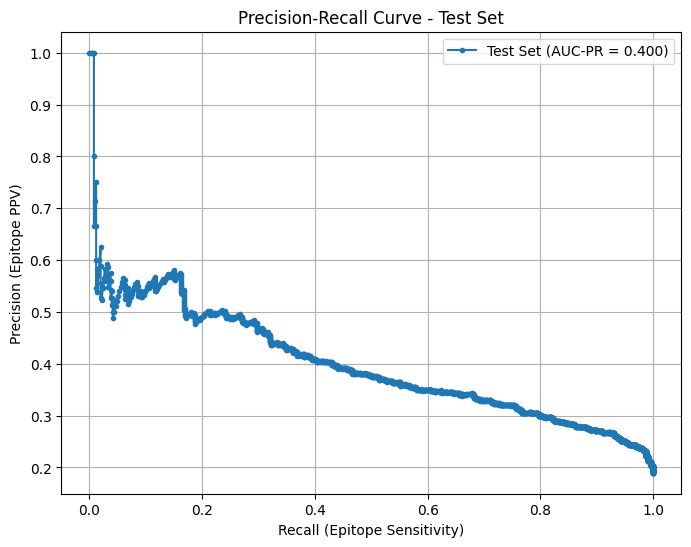

In [63]:
print("\n--- Test Set Performance ---")

if not all_test_labels_list:
    print("No valid labels/predictions collected from the test set. Cannot calculate metrics.")
else:
    # Convert collected lists to numpy arrays
    all_test_labels_np = np.array(all_test_labels_list).astype(int)
    all_test_preds_prob_np = np.array(all_test_preds_prob)

    # --- Calculate Metrics ---
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        all_test_labels_np,
        (all_test_preds_prob_np >= 0.5).astype(int), # Use 0.5 threshold for these metrics
        average='binary',
        zero_division=0
    )

    # Calculate AUCs 
    test_auc_roc = 0.0
    test_auc10 = 0.0
    test_auc_pr = 0.0

    unique_labels_test = np.unique(all_test_labels_np)
    if len(unique_labels_test) < 2:
        print(f"Warning: Only one class ({unique_labels_test}) present in test labels. AUC-ROC/AUC10 set to 0.0.")
        try:
             # AUC-PR might be 1.0 if only positive class, 0.0/NaN otherwise
             test_auc_pr = average_precision_score(all_test_labels_np, all_test_preds_prob_np)
             if np.isnan(test_auc_pr): test_auc_pr = 0.0
        except ValueError: test_auc_pr = 0.0
    else: # Both classes present
        try:
            test_auc_pr = average_precision_score(all_test_labels_np, all_test_preds_prob_np)
        except ValueError as e:
            print(f"Warning: Test AUC-PR calculation error: {e}")
        try:
            test_auc_roc = roc_auc_score(all_test_labels_np, all_test_preds_prob_np)
            try:
                if len(all_test_labels_np) > 10:
                     test_auc10 = roc_auc_score(all_test_labels_np, all_test_preds_prob_np, max_fpr=0.1)
                else: print("Warning: Low sample count for AUC10.")
            except ValueError: print("Warning: AUC10 calculation failed.")
        except ValueError as e:
            print(f"Warning: Test AUC-ROC calculation error: {e}")

    # Calculate Confusion Matrix
    try:
        test_cm = confusion_matrix(
            all_test_labels_np,
            (all_test_preds_prob_np >= 0.5).astype(int),
            labels=[0, 1] 
        )
    except ValueError as e:
        print(f"Warning: Could not compute confusion matrix: {e}")
        test_cm = np.zeros((2, 2), dtype=int) # Default to zeros

    # --- Print Metrics ---
    print(f"  AUC-PR: {test_auc_pr:.4f}")
    print(f"  AUC-ROC: {test_auc_roc:.4f}")
    print(f"  AUC10 (max_fpr=0.1): {test_auc10:.4f}")
    print(f"  F1-Score: {test_f1:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall: {test_recall:.4f}")

    print("\n  Confusion Matrix (Rows: Actual, Cols: Predicted @ 0.5 Threshold):")
    print(f"        Predicted 0    Predicted 1")
    print(f"Actual 0 | {test_cm[0, 0]:<12} | {test_cm[0, 1]:<12} | (TN={test_cm[0, 0]}, FP={test_cm[0, 1]})")
    print(f"Actual 1 | {test_cm[1, 0]:<12} | {test_cm[1, 1]:<12} | (FN={test_cm[1, 0]}, TP={test_cm[1, 1]})")
    print(f"--------------------------------------------------------------------")

    # Optional: Plot PR Curve
    precision_curve, recall_curve, _ = precision_recall_curve(all_test_labels_np, all_test_preds_prob_np)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, marker='.', label=f'Test Set (AUC-PR = {test_auc_pr:.3f})')
    plt.xlabel('Recall (Epitope Sensitivity)')
    plt.ylabel('Precision (Epitope PPV)')
    plt.title('Precision-Recall Curve - Test Set')
    plt.grid(True)
    plt.legend()
    plt.show()

## Identify and visualize best and worst

In [64]:
if protein_results:
    print("\n--- Per-Protein AUC-PR (Example) ---")
    # Sort proteins by AUC-PR (descending)
    sorted_proteins = sorted(protein_results.items(), key=lambda item: item[1]['f1'], reverse=True)
    for i, (name, results) in enumerate(sorted_proteins):
         print(f"{name}: F1 = {results['f1']:.4f}")
         if i >= 20: # Show top 10
              print("...")
              break
    print("-------------------------------------")


--- Per-Protein AUC-PR (Example) ---
7chz_I: F1 = 0.6133
4ypg_D: F1 = 0.5403
7jum_A: F1 = 0.5150
4xak_A: F1 = 0.4887
6y6c_A: F1 = 0.4545
3pnw_O: F1 = 0.4444
2xwt_C: F1 = 0.4412
7lj4_B: F1 = 0.4296
4qci_D: F1 = 0.4000
6vtw_A: F1 = 0.4000
5f72_K: F1 = 0.3910
5th9_A: F1 = 0.3333
5d8j_A: F1 = 0.3297
6u6u_R: F1 = 0.2712
6hga_B: F1 = 0.1224
-------------------------------------



Generating visualizations for: ['7chz_I', '6hga_B']

--- Visualization for Protein: 7chz_I ---
Length (visualized): 152
Performance Metrics: F1 = 0.6133, Accuracy = 0.6184
True Epitopes (54 residues):
pvrslnctlrdsQqkslVMSGPYElKaLHLQgQDmEQQvVfsmsfvqgeesndkipvalg
lkEKNLylscVLKDdkptlQLESVDPKNYpKkKmEKRfvfnkieinnklefesAQFPnwy
istsQAENMPvflggtkgGQditdftmqfvss

Predicted Epitopes (96 residues @ 0.5 threshold):
pvRSLNctlRdSQQKslvmSGPYElKaLHLQGQDMEQQvvfsmsFvQgEESNDKipvalg
lKEKNlylscvLKDDKPTlQleSVDPKNYPKKKMEKRfvfNkIEINNKlEfesaQFPNWy
istsQAENMPvFlGGTKGGQDITDfTmQFvSs


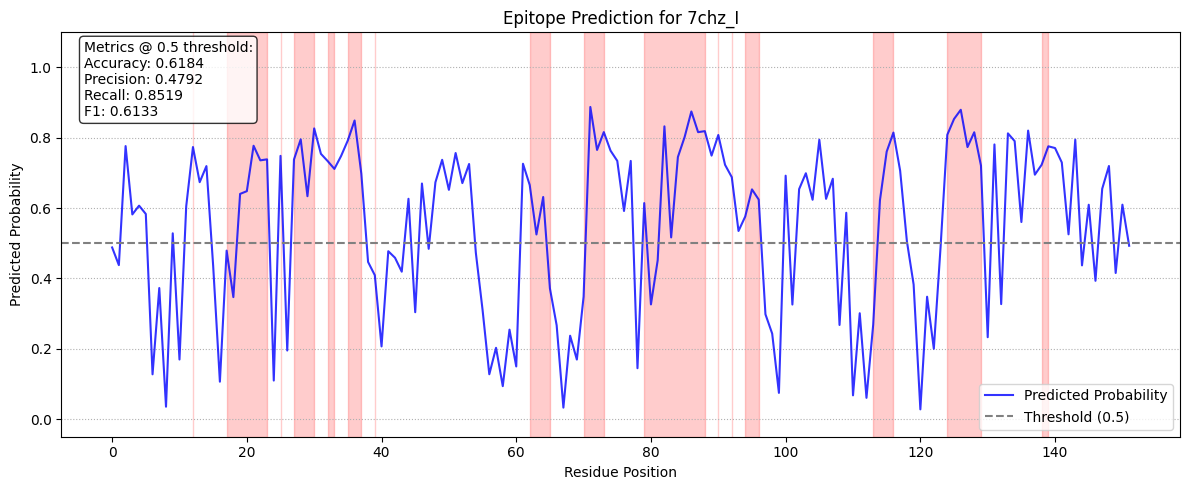

-------------------------------------------------

--- Visualization for Protein: 6hga_B ---
Length (visualized): 263
Performance Metrics: F1 = 0.1224, Accuracy = 0.8365
True Epitopes (12 residues):
lpwlnvsadgdnvhlvlnvseeqhfglslywnqvqgppkprwhknltgpqiitlqhtdlv
pclciqvwplepdsvrtnicpfredprahqnlwqaarlrlltlqswlldapcslpaeaal
cwrapggdpcqplvpplsweqvtvdkvlefpllkghpnlcvqvqsseklqlqeclwadsl
gplkddvllletrgpqdqrslcalepsgctslpsKaStraaRLgEYllqdlqsgqclqlw
dddlgalwacpmdkyihKREFRH

Predicted Epitopes (37 residues @ 0.5 threshold):
lpwlnvsadgdnvhlvlnvseeqHfGlslywnqvqgPPKpRWHknltgpqiitlqhtdlv
pclciqvwpLEPdsvrtnicpfredpRahqnlwqaarlrlltlqswlldapcslpaEaAl
cwraPgGDpCqPlVPpLsweqvtvdkvlefpllkghpNlcvqvQssEklqlqeclwadsl
gplkddvllletrgpqdqrslcaLEpSgctslPskastraaRlGeYllqdlQsgqclqlW
dDdlgalWacpmdkyihkrEfrh


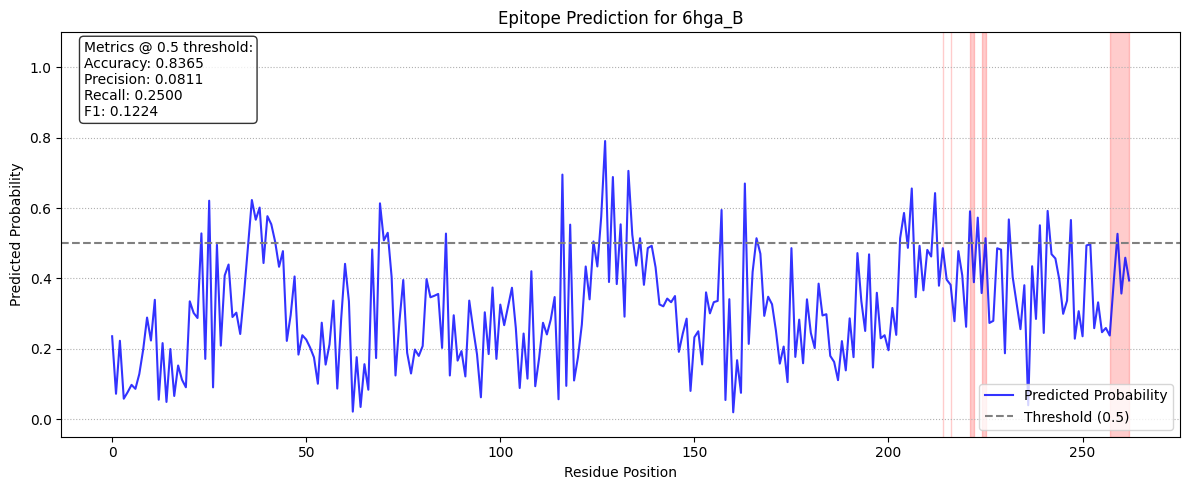

-------------------------------------------------


In [65]:

if 'protein_results' in locals() and isinstance(protein_results, dict):
    VISUALIZATION_THRESHOLD = 0.5
    
    # Best and worst performers based on your data
    PROTEINS_TO_VISUALIZE = ['7chz_I', '6hga_B']  # Best and worst 
    
    if not PROTEINS_TO_VISUALIZE:
         print("No proteins selected for visualization.")
    else:
        print(f"\nGenerating visualizations for: {PROTEINS_TO_VISUALIZE}")
        # Ensure H5_TEST_PATH is defined from previous cells
        if 'H5_TEST_PATH' not in locals() or not H5_TEST_PATH:
             print("Error: H5_TEST_PATH variable not defined. Cannot load sequences.")
        else:
            for protein_id in PROTEINS_TO_VISUALIZE:
                if protein_id in protein_results:
                    sequence = load_sequence_from_h5(H5_TEST_PATH, protein_id)
                    true_labels = protein_results[protein_id]['labels']
                    predicted_probs = protein_results[protein_id]['probabilities']
                    visualize_protein_predictions_standalone(
                        protein_id, sequence, true_labels, predicted_probs, threshold=VISUALIZATION_THRESHOLD
                    )
                else:
                    print(f"Protein ID '{protein_id}' not found in collected results.")
else:
    print("Variable 'protein_results' not found or is not a dictionary. Make sure the evaluation cell ran successfully.")

# XGBooost

In [66]:
model_type = 'xgboost'
H5_TEST_PATH
JSON_SELECTED = JSON_PATH[model_type][embedding_type]
SELECTED_BEST_MODEL = BEST_MODEL_PATH[model_type][embedding_type]

print(H5_TEST_PATH, JSON_SELECTED, SELECTED_BEST_MODEL)

esm2_test_protein_embeddings.h5 final_training/xgboost/esm2/esm2_xgb_final_results_summary.json final_training/xgboost/esm2/esm2_xgb_final_model.json


## Config

In [67]:
FINAL_MODEL_PATH = SELECTED_BEST_MODEL

THRESHOLD = 0.5 

if not os.path.isfile(FINAL_MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {FINAL_MODEL_PATH}")
if not os.path.isfile(H5_TEST_PATH):
    raise FileNotFoundError(f"Test data file not found: {H5_TEST_PATH}")

print(f"Using Embedding Type: {embedding_type}")
print(f"Model Path:          {FINAL_MODEL_PATH}")
print(f"Test Data Path:      {H5_TEST_PATH}")
print(f"Evaluation Threshold:{THRESHOLD}")

Using Embedding Type: esm2
Model Path:          final_training/xgboost/esm2/esm2_xgb_final_model.json
Test Data Path:      esm2_test_protein_embeddings.h5
Evaluation Threshold:0.5


### Initiate model 

In [68]:
import xgboost as xgb
import matplotlib.pyplot as plt
import graphviz 

# --- Load your saved final model ---
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(FINAL_MODEL_PATH)
print("Model loaded successfully.")


Model loaded successfully.


### Function to make data into DMatrix

In [69]:
def load_and_aggregate_data(h5_path, description="Data"):
    print(f"Embedding Type: {embedding_type}")
    
    """Loads embeddings and labels from HDF5 and aggregates them."""
    print(f"\n--- Loading and Aggregating {description} from {h5_path} ---")
    embeddings_list = []
    labels_list = []
    protein_keys = []

    try:
        with h5py.File(h5_path, 'r') as f:
            if 'embeddings_folder' not in f:
                raise KeyError("Group 'embeddings_folder' not found in HDF5 file.")
            keys_in_file = list(f['embeddings_folder'].keys())
            protein_keys.extend(keys_in_file)

            print(f"--> Found {len(keys_in_file)} protein keys in {description} file.")
            embeddings_group = f['embeddings_folder']
            for protein_key in tqdm.tqdm(keys_in_file, desc=f"Loading {description} Embeddings"):
                try:
                    protein_group = embeddings_group[protein_key]
                    # Ensure data is loaded as float32 for embeddings, int32 for labels
                    embeddings = protein_group['embeddings'][:].astype(np.float32)
                    labels = protein_group['labels'][:].astype(np.int32)
                    embeddings_list.append(embeddings)
                    labels_list.append(labels)
                except KeyError:
                    print(f"Warning: Protein key '{protein_key}' found in list but not accessible. Skipping.")
                except Exception as load_err:
                    print(f"Warning: Error loading data for protein '{protein_key}'. Skipping. Error: {load_err}")

        if not embeddings_list:
             raise ValueError(f"Error: No embeddings were successfully loaded for {description}.")

        # Concatenate into large NumPy arrays
        X_data = np.concatenate(embeddings_list, axis=0)
        y_data = np.concatenate(labels_list, axis=0)

        print(f"\n{description} Data Shapes:")
        print(f"  X_{description.lower()}: {X_data.shape}, y_{description.lower()}: {y_data.shape}")
        # Cleanup
        del embeddings_list, labels_list
        gc.collect()
        print(f"--- {description} Aggregation Complete ---")
        return X_data, y_data, protein_keys

    except FileNotFoundError:
        print(f"Error: HDF5 file not found at {h5_path}")
        raise
    except KeyError as e:
        print(f"Error: Problem accessing data within HDF5 file '{h5_path}'. {e}")
        raise
    except ValueError as e:
         print(f"Error during concatenation for {description}: {e}. Likely empty list or shape mismatch.")
         raise
    except Exception as e:
        print(f"An unexpected error occurred while loading {description} data: {e}")
        raise

### Loading in data

In [70]:
import h5py
import tqdm
import numpy as np
import gc

print(f"\n--- Loading Final Model from {FINAL_MODEL_PATH} ---")
final_xgb_model = xgb.Booster()
try:
    final_xgb_model.load_model(FINAL_MODEL_PATH)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading XGBoost model: {e}")
    raise # Stop execution if model doesn't load

# --- Load the Test Data ---
X_test, y_test, test_keys = load_and_aggregate_data(H5_TEST_PATH, "Test Data")

# --- Prepare DMatrix for Test Data ---
print("\n--- Preparing Test Data for XGBoost (DMatrix) ---")
try:
    # Note: Including labels here is optional for prediction but doesn't hurt
    dtest = xgb.DMatrix(X_test, label=y_test)
    print("Test DMatrix created successfully.")
except Exception as e:
    print(f"Error creating DMatrix for test data: {e}")
    raise


--- Loading Final Model from final_training/xgboost/esm2/esm2_xgb_final_model.json ---
Model loaded successfully.
Embedding Type: esm2

--- Loading and Aggregating Test Data from esm2_test_protein_embeddings.h5 ---
--> Found 15 protein keys in Test Data file.


Loading Test Data Embeddings: 100%|██████████| 15/15 [00:00<00:00, 1075.15it/s]


Test Data Data Shapes:
  X_test data: (2670, 1280), y_test data: (2670,)
--- Test Data Aggregation Complete ---

--- Preparing Test Data for XGBoost (DMatrix) ---


Test DMatrix created successfully.


## Make predictions

In [71]:
# --- Predict Probabilities on Test Set ---
print(f"Embedding Type: {embedding_type}")

print("\n--- Predicting on Test Set ---")
try:
    y_pred_prob_test = final_xgb_model.predict(dtest)
    print(f"Predictions generated successfully. Shape: {y_pred_prob_test.shape}")
except Exception as e:
    print(f"Error during prediction: {e}")
    raise

# --- Convert Probabilities to Binary Predictions ---
y_pred_binary_test = (y_pred_prob_test >= THRESHOLD).astype(int)
print(f"\nConverted probabilities to binary predictions using threshold: {THRESHOLD}")
xgb_stuff = y_pred_prob_test

Embedding Type: esm2

--- Predicting on Test Set ---
Predictions generated successfully. Shape: (2670,)

Converted probabilities to binary predictions using threshold: 0.5


### Calculate Metrics

In [72]:
print(f"\n --- Embedding type: {embedding_type} ---")

print("\n--- Calculating Evaluation Metrics ---")
test_results = {}
test_results['threshold_used'] = THRESHOLD

try:
    # --- Probability-based Metrics ---
    print("Calculating probability-based metrics (AUC-PR, AUC-ROC)...")
    test_auc_pr = average_precision_score(y_test, y_pred_prob_test)
    test_results['auc_pr'] = test_auc_pr

    # Handle potential error if only one class present in y_test for ROC AUC
    try:
        test_auc_roc = roc_auc_score(y_test, y_pred_prob_test)
        test_results['auc_roc'] = test_auc_roc
    except ValueError:
        print("Warning: Only one class present in y_test. AUC ROC set to 0.0.")
        test_auc_roc = 0.0
        test_results['auc_roc'] = 0.0 # Store 0.0

    try:
        test_auc10 = roc_auc_score(y_test, y_pred_prob_test, max_fpr=0.1)
        test_results['auc10'] = test_auc10
    except ValueError:
        print("Warning: Could not calculate AUC10 (max_fpr=0.1). Set to 0.0.")
        test_auc10 = 0.0
        test_results['auc10'] = 0.0 # Store 0.0

    # --- Threshold-based Metrics ---
    # --- ADD THESE CHECKS ---
    print("\n --- Checking Shapes --- ")
    print("Shape of y_test:", y_test.shape)
    print("Unique values in y_test:", np.unique(y_test, return_counts=True))
    print("Shape of y_pred_binary_test:", y_pred_binary_test.shape)
    print("Unique values in y_pred_binary_test:", np.unique(y_pred_binary_test, return_counts=True))
    # Check if any positive predictions were made
    if np.sum(y_pred_binary_test == 1) == 0:
        print("WARNING: y_pred_binary_test contains only zeros! This will result in F1/Precision/Recall=0.")
    # --- END CHECKS ---

    print(f"Calculating threshold-based metrics (F1, Precision, Recall, CM) using threshold={THRESHOLD}...")
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        y_test, y_pred_binary_test, average='binary', zero_division=0
    )
    test_results['f1'] = test_f1
    test_results['precision'] = test_precision
    test_results['recall'] = test_recall

    # --- Confusion Matrix ---
    test_cm = confusion_matrix(y_test, y_pred_binary_test, labels=[0, 1]) # Ensure consistent label order [TN, FP], [FN, TP]
    tn, fp, fn, tp = test_cm.ravel()
    test_results['true_neg'] = int(tn)
    test_results['false_pos'] = int(fp)
    test_results['false_neg'] = int(fn)
    test_results['true_pos'] = int(tp)
    test_results['num_test_samples'] = len(y_test)
    test_results['num_pos_test'] = int(np.sum(y_test == 1))
    test_results['num_neg_test'] = int(np.sum(y_test == 0))

    print("\n--- Test Set Evaluation Results ---")
    print(f"Threshold Used:            {THRESHOLD}")
    print("-------------------------------------")
    print(f"AUC-PR:                    {test_results['auc_pr']:.4f}")
    print(f"AUC-ROC:                   {test_results['auc_roc']:.4f}")
    print(f"AUC10 (AUC-ROC @ FPR=0.1): {test_results['auc10']:.4f}")
    print("-------------------------------------")
    print(f"F1 Score:                  {test_results['f1']:.4f}")
    print(f"Precision:                 {test_results['precision']:.4f}")
    print(f"Recall (Sensitivity):      {test_results['recall']:.4f}")
    print("-------------------------------------")
    print(f"Confusion Matrix:")
    print(f"  True Negatives (TN):     {test_results['true_neg']}")
    print(f"  False Positives (FP):    {test_results['false_pos']}")
    print(f"  False Negatives (FN):    {test_results['false_neg']}")
    print(f"  True Positives (TP):     {test_results['true_pos']}")
    print("-------------------------------------")
    print(f"Total Test Samples:        {test_results['num_test_samples']}")
    print(f"  Positive Samples:        {test_results['num_pos_test']}")
    print(f"  Negative Samples:        {test_results['num_neg_test']}")
    print("-------------------------------------")

except Exception as e:
    print(f"\nAn error occurred during metric calculation: {e}")
    # Optionally re-raise the exception if you want the notebook to stop
    # raise e


 --- Embedding type: esm2 ---

--- Calculating Evaluation Metrics ---
Calculating probability-based metrics (AUC-PR, AUC-ROC)...

 --- Checking Shapes --- 
Shape of y_test: (2670,)
Unique values in y_test: (array([0, 1], dtype=int32), array([2163,  507]))
Shape of y_pred_binary_test: (2670,)
Unique values in y_pred_binary_test: (array([0, 1]), array([1981,  689]))
Calculating threshold-based metrics (F1, Precision, Recall, CM) using threshold=0.5...

--- Test Set Evaluation Results ---
Threshold Used:            0.5
-------------------------------------
AUC-PR:                    0.3725
AUC-ROC:                   0.7401
AUC10 (AUC-ROC @ FPR=0.1): 0.5616
-------------------------------------
F1 Score:                  0.4247
Precision:                 0.3687
Recall (Sensitivity):      0.5010
-------------------------------------
Confusion Matrix:
  True Negatives (TN):     1728
  False Positives (FP):    435
  False Negatives (FN):    253
  True Positives (TP):     254
----------------

## Visuals


--- Visualizing ROC and PR Curves ---


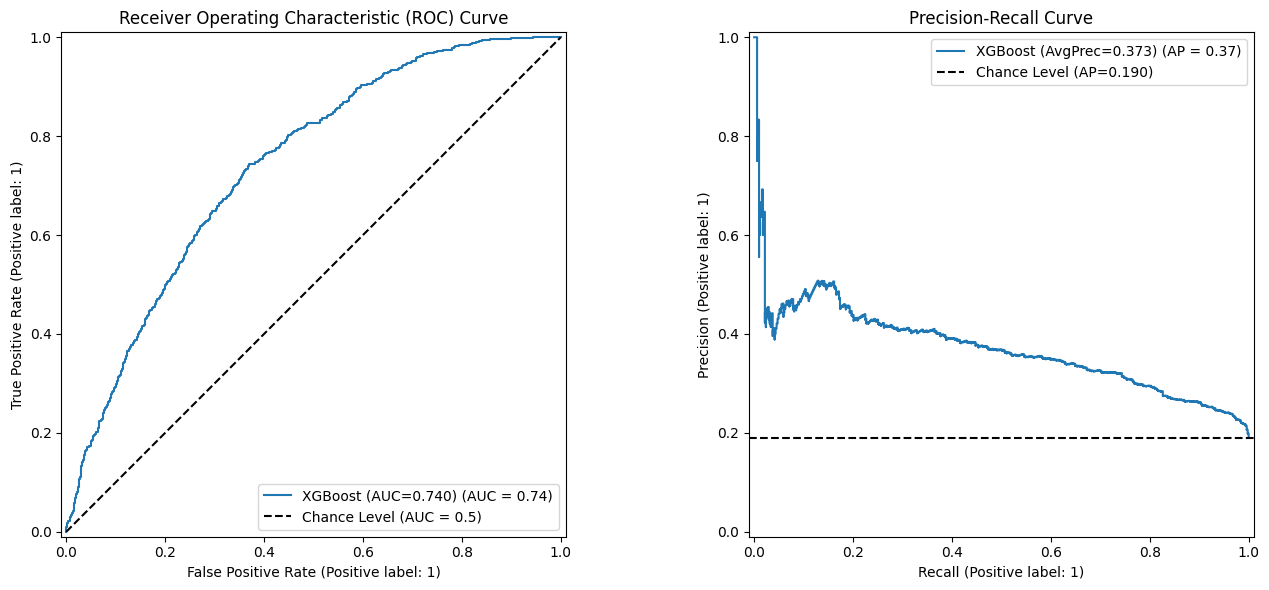

In [73]:
# --- Visualize ROC and Precision-Recall Curves ---
print("\n--- Visualizing ROC and PR Curves ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob_test, ax=ax1, name=f'XGBoost (AUC={test_auc_roc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_pred_prob_test, ax=ax2, name=f'XGBoost (AvgPrec={test_auc_pr:.3f})')
# Calculate chance level for PR curve (proportion of positive samples)
chance_level_pr = test_results['num_pos_test'] / test_results['num_test_samples']
ax2.axhline(chance_level_pr, color='k', linestyle='--', label=f'Chance Level (AP={chance_level_pr:.3f})')
ax2.set_title('Precision-Recall Curve')
ax2.legend()


plt.tight_layout()
plt.show()

### Model Info

Model has 1361 trees.


/home/jgg/.local/lib/python3.10/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


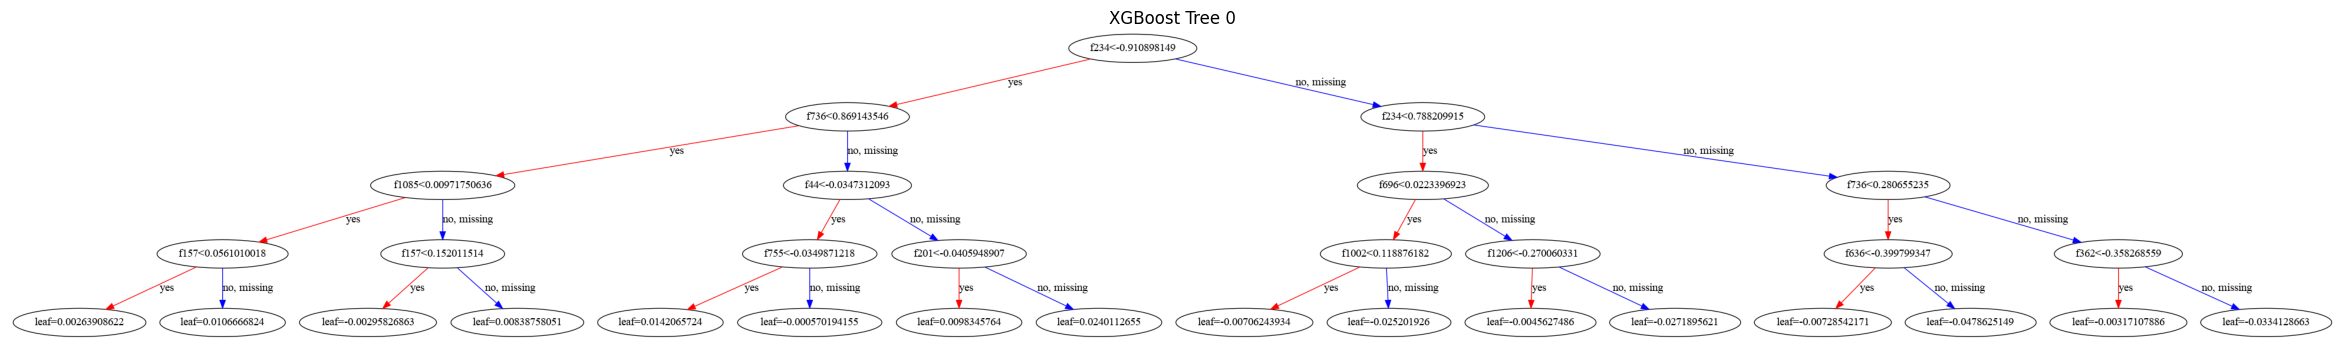

Saved plot for tree 0


In [74]:
num_trees = final_xgb_model.num_boosted_rounds()
print(f"Model has {num_trees} trees.")

tree_index_to_plot = 0 # Change this to view different trees (0 to num_trees-1)

if tree_index_to_plot < num_trees:
    fig, ax = plt.subplots(figsize=(30, 15)) # Adjust figsize as needed
    xgb.plot_tree(final_xgb_model, num_trees=tree_index_to_plot, ax=ax)
    plt.title(f'XGBoost Tree {tree_index_to_plot}')
    plt.savefig(f'xgboost_tree_{tree_index_to_plot}.png', dpi=300) # Save the plot
    plt.show()
    print(f"Saved plot for tree {tree_index_to_plot}")
else:
    print(f"Error: Tree index {tree_index_to_plot} is out of bounds (0-{num_trees-1}).")

# Ensemble Model

## Finding optimal weights

In [75]:
from itertools import product
def find_optimal_weights(ensemble_df, n_steps=11):
    # Create weight combinations
    weight_step = 1.0 / (n_steps - 1) if n_steps > 1 else 1.0
    weight_values = [round(i * weight_step, 2) for i in range(n_steps)]
    
    # Generate weight combinations that sum to 1.0
    weight_combinations = []
    for weights in product(weight_values, repeat=3):
        if abs(sum(weights) - 1.0) < 1e-6:  # Check if weights sum to 1.0 (with floating point tolerance)
            weight_combinations.append(weights)
    
    print(f"Evaluating {len(weight_combinations)} weight combinations...")
    
    # Initialize performance tracking
    performance = []
    
    # Evaluate each weight combination directly on the entire dataset
    for weights in weight_combinations:
        xgb_weight, mlp_weight, transformer_weight = weights
        
        # Calculate weighted probability
        weighted_prob = (
            xgb_weight * ensemble_df['xgboost_prob'] + 
            mlp_weight * ensemble_df['mlp_prob'] + 
            transformer_weight * ensemble_df['transformer_prob']
        )
        
        # Convert to binary prediction
        weighted_pred = (weighted_prob >= 0.5).astype(int)
        
        # Calculate metrics
        f1 = f1_score(ensemble_df['true_label'], weighted_pred)
        auc = roc_auc_score(ensemble_df['true_label'], weighted_prob)
        ap = average_precision_score(ensemble_df['true_label'], weighted_prob)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(ensemble_df['true_label'], weighted_pred).ravel()
        
        performance.append({
            'XGBoost_weight': xgb_weight,
            'MLP_weight': mlp_weight,
            'Transformer_weight': transformer_weight,
            'F1': f1,
            'AUC': auc,
            'AP': ap,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'TP': tp
        })
    
    # Convert to DataFrame for easier analysis
    performance_df = pd.DataFrame(performance)
    
    # Find optimal weights based on F1 score
    best_idx = performance_df['F1'].idxmax()
    optimal_weights = [
        performance_df.iloc[best_idx]['XGBoost_weight'],
        performance_df.iloc[best_idx]['MLP_weight'],
        performance_df.iloc[best_idx]['Transformer_weight']
    ]
    
    best_confusion_matrix = [
        performance_df.iloc[best_idx]['TN'],
        performance_df.iloc[best_idx]['FP'],
        performance_df.iloc[best_idx]['FN'],
        performance_df.iloc[best_idx]['TP']
    ]
    
    print("\nTop 5 Weight Combinations by F1 Score:")
    print(performance_df.sort_values('F1', ascending=False).head(5))
    
    print(f"\nOptimal weights: XGBoost={optimal_weights[0]:.2f}, MLP={optimal_weights[1]:.2f}, Transformer={optimal_weights[2]:.2f}")
    print(f"Best F1 Score: {performance_df.iloc[best_idx]['F1']:.4f}")
    print(f"Corresponding AUC: {performance_df.iloc[best_idx]['AUC']:.4f}")
    print(f"Corresponding AP: {performance_df.iloc[best_idx]['AP']:.4f}")
    print(f"Confusion Matrix: TN={best_confusion_matrix[0]}, FP={best_confusion_matrix[1]}, FN={best_confusion_matrix[2]}, TP={best_confusion_matrix[3]}")

    
    return optimal_weights, performance_df, best_confusion_matrix

# Then modify these functions to use the new simplified approach:
def flatten_protein_dict(protein_dict):
    all_probs = []
    all_labels = []
    protein_ids = []
    
    for protein_id, data in protein_dict.items():
        probs = data['probabilities']
        labels = data['labels']
        
        all_probs.extend(probs)
        all_labels.extend(labels)
        protein_ids.extend([protein_id] * len(probs))
    
    return all_probs, all_labels, protein_ids

def create_ensemble_predictions(xgboost_probs, mlp_data, transformer_data):
    # First, check if the three data sources are compatible
    # Extract and flatten MLP and transformer data
    mlp_probs, mlp_labels, mlp_proteins = flatten_protein_dict(mlp_data)
    transformer_probs, transformer_labels, transformer_proteins = flatten_protein_dict(transformer_data)
    
    # Create ensemble DataFrame
    ensemble_df = create_ensemble_dataframe(xgboost_probs, mlp_probs, mlp_labels, 
                                            transformer_probs, mlp_proteins, transformer_proteins)
    
    # Find optimal weights for the ensemble
    optimal_weights, weight_performance, best_confusion_matrix = find_optimal_weights(ensemble_df)
    
    # Apply ensemble methods with optimal weights
    return apply_ensemble_methods(ensemble_df, weights=optimal_weights), weight_performance, best_confusion_matrix

def create_ensemble_dataframe(xgboost_probs, mlp_probs, mlp_labels, transformer_probs, mlp_proteins, transformer_proteins):
    # Determine if we can align the data by protein
    if len(mlp_proteins) == len(transformer_proteins) and all(m == t for m, t in zip(mlp_proteins, transformer_proteins)):
        print("Data is aligned by protein. Creating ensemble...")
        ensemble_df = pd.DataFrame({
            'protein_id': mlp_proteins,
            'mlp_prob': mlp_probs,
            'transformer_prob': transformer_probs,
            'true_label': mlp_labels  # Assuming labels are consistent
        })
        
        # Check if xgboost data has the same length
        if len(xgboost_probs) == len(ensemble_df):
            ensemble_df['xgboost_prob'] = xgboost_probs
        else:
            print(f"Warning: XGBoost has {len(xgboost_probs)} samples vs {len(ensemble_df)} for other models")
            raise ValueError("XGBoost probabilities don't match other models. Data alignment required.")
    else:
        print("Data is not aligned by protein. Creating ensemble with raw probabilities...")
        # If length matches, we can still try to create an ensemble
        if len(xgboost_probs) == len(mlp_probs) == len(transformer_probs):
            ensemble_df = pd.DataFrame({
                'xgboost_prob': xgboost_probs,
                'mlp_prob': mlp_probs,
                'transformer_prob': transformer_probs,
                'true_label': mlp_labels  # Assuming labels are consistent
            })
        else:
            # If lengths don't match, we need manual alignment
            print(f"Warning: Length mismatch: XGBoost={len(xgboost_probs)}, MLP={len(mlp_probs)}, Transformer={len(transformer_probs)}")
            raise ValueError("Model outputs have different lengths. Data alignment required.")
    
    return ensemble_df

def apply_ensemble_methods(ensemble_df, weights=None):
    # Set default weights if not provided
    if weights is None:
        weights = [0.33, 0.33, 0.34]  # Equal weights by default
    
    # Simple average ensemble
    ensemble_df['avg_prob'] = ensemble_df[['xgboost_prob', 'mlp_prob', 'transformer_prob']].mean(axis=1)
    
    # Weighted average ensemble with optimal weights
    ensemble_df['weighted_prob'] = (
        weights[0] * ensemble_df['xgboost_prob'] + 
        weights[1] * ensemble_df['mlp_prob'] + 
        weights[2] * ensemble_df['transformer_prob']
    )
    
    # Convert probabilities to binary predictions (threshold=0.5)
    threshold = 0.5
    for col in ['xgboost_prob', 'mlp_prob', 'transformer_prob', 'avg_prob', 'weighted_prob']:
        pred_col = col.replace('prob', 'pred')
        ensemble_df[pred_col] = (ensemble_df[col] >= threshold).astype(int)
    
    # Majority voting ensemble
    ensemble_df['vote_pred'] = ((ensemble_df['xgboost_pred'] + 
                                ensemble_df['mlp_pred'] + 
                                ensemble_df['transformer_pred']) >= 2).astype(int)
    
    # Add optimized weights to column names for clarity
    ensemble_df = ensemble_df.rename(columns={
        'weighted_prob': f'weighted_prob_{weights[0]:.2f}_{weights[1]:.2f}_{weights[2]:.2f}',
        'weighted_pred': f'weighted_pred_{weights[0]:.2f}_{weights[1]:.2f}_{weights[2]:.2f}'
    })
    
    return ensemble_df

In [78]:
matrix = create_ensemble_predictions(xgb_stuff, mlp_stuff, transformer_stuff)

Data is aligned by protein. Creating ensemble...
Evaluating 66 weight combinations...

Top 5 Weight Combinations by F1 Score:
    XGBoost_weight  MLP_weight  Transformer_weight        F1       AUC  \
34             0.3         0.4                 0.3  0.466798  0.762233   
25             0.2         0.4                 0.4  0.465506  0.761318   
42             0.4         0.4                 0.2  0.463924  0.761518   
41             0.4         0.3                 0.3  0.463466  0.760431   
47             0.5         0.2                 0.3  0.463343  0.757351   

          AP    TN   FP   FN   TP  
34  0.399111  1504  659  152  355  
25  0.395707  1480  683  146  361  
42  0.400105  1531  632  163  344  
41  0.395603  1566  597  174  333  
47  0.389954  1622  541  191  316  

Optimal weights: XGBoost=0.30, MLP=0.40, Transformer=0.30
Best F1 Score: 0.4668
Corresponding AUC: 0.7622
Corresponding AP: 0.3991
Confusion Matrix: TN=1504.0, FP=659.0, FN=152.0, TP=355.0


Data is aligned by protein. Creating ensemble...
Evaluating 66 weight combinations...

Top 5 Weight Combinations by F1 Score:
    XGBoost_weight  MLP_weight  Transformer_weight        F1       AUC  \
34             0.3         0.4                 0.3  0.466798  0.762233   
25             0.2         0.4                 0.4  0.465506  0.761318   
42             0.4         0.4                 0.2  0.463924  0.761518   
41             0.4         0.3                 0.3  0.463466  0.760431   
47             0.5         0.2                 0.3  0.463343  0.757351   

          AP    TN   FP   FN   TP  
34  0.399111  1504  659  152  355  
25  0.395707  1480  683  146  361  
42  0.400105  1531  632  163  344  
41  0.395603  1566  597  174  333  
47  0.389954  1622  541  191  316  

Optimal weights: XGBoost=0.30, MLP=0.40, Transformer=0.30
Best F1 Score: 0.4668
Corresponding AUC: 0.7622
Corresponding AP: 0.3991
Confusion Matrix: TN=1504.0, FP=659.0, FN=152.0, TP=355.0


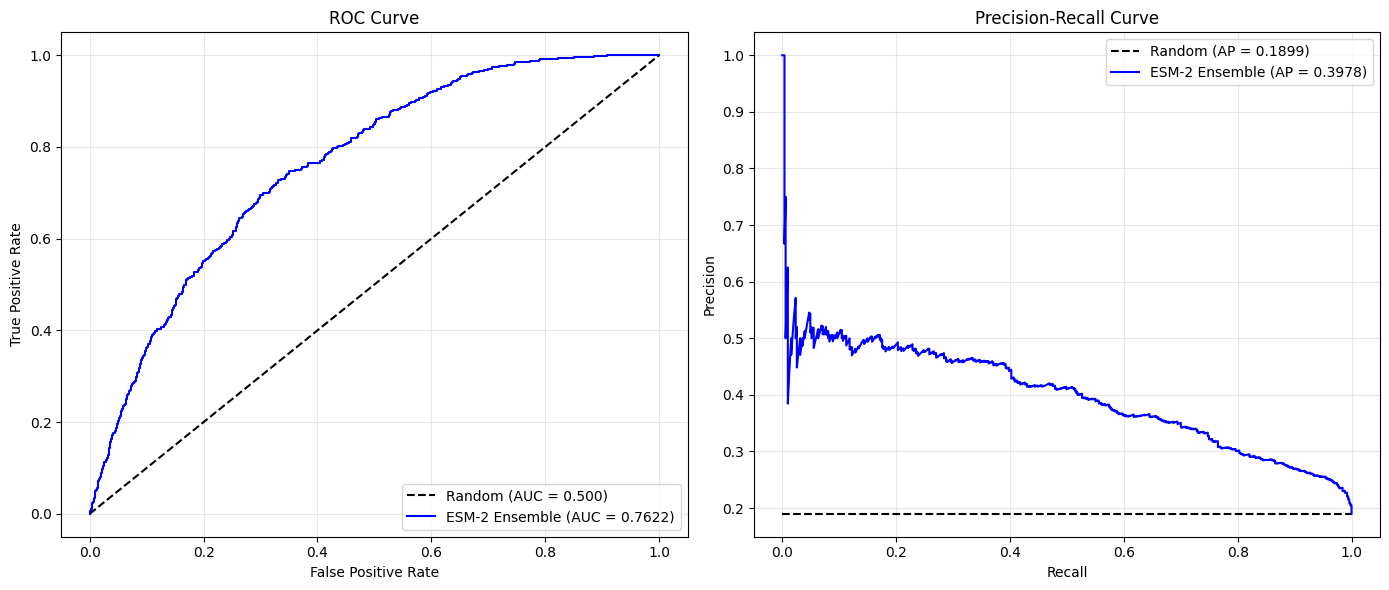

In [79]:
# First, create the ensemble DataFrame using your existing function
ensemble_results, weight_performance, best_confusion_matrix = create_ensemble_predictions(
    xgboost_probs=xgb_stuff,  # Your flattened XGBoost probabilities
    mlp_data=mlp_stuff,       # Your MLP data dictionary
    transformer_data=transformer_stuff  # Your transformer data dictionary
)

# The first return value is your ensemble DataFrame
ensemble_df = ensemble_results

# Now you can plot the curves for your best model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def plot_best_model_curves(ensemble_df, prob_column, true_label_column='true_label', 
                          figsize=(14, 6), model_name="ESM-2 Ensemble"):
    """
    Plot ROC and Precision-Recall curves for the best model
    """
    # Get true labels and model probabilities
    y_true = ensemble_df[true_label_column].values
    y_score = ensemble_df[prob_column].values
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Calculate and plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    ax1.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
    ax1.plot(fpr, tpr, color='blue', label=f'{model_name} (AUC = {roc_auc:.4f})')
    
    # Calculate and plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    
    # Calculate random baseline (proportion of positive class)
    baseline = y_true.mean()
    ax2.plot([0, 1], [baseline, baseline], 'k--', 
             label=f'Random (AP = {baseline:.4f})')
    ax2.plot(recall, precision, color='blue', 
             label=f'{model_name} (AP = {pr_auc:.4f})')
    
    # Set ROC curve plot properties
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc='lower right')
    ax1.grid(alpha=0.3)
    
    # Set Precision-Recall curve plot properties
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('esm2_ensemble_curves.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('esm2_ensemble_curves.png', dpi=300, bbox_inches='tight')
    
    return fig

# Find the column name for the weighted probabilities with your optimal weights
# This should be something like 'weighted_prob_0.30_0.40_0.30' based on your optimal weights
weighted_prob_column = [col for col in ensemble_df.columns if 'weighted_prob_' in col][0]

# Plot the curves for your best model
fig = plot_best_model_curves(
    ensemble_df, 
    prob_column=weighted_prob_column,
    model_name="ESM-2 Ensemble"
)
plt.show()

## Generate predictions for identified weights

In [80]:
def calculate_ensemble_metrics_per_protein(
    flat_xgboost_probs,       # Flat NumPy array (your xgb_stuff)
    mlp_protein_data,         # Dict: {protein_id: {'probabilities': list/array, 'labels': list/array}}
    transformer_protein_data, # Dict: {protein_id: {'probabilities': list/array, 'labels': list/array}}
    optimal_weights,          # List: [xgb_weight, mlp_weight, transformer_weight]
    threshold=0.5             # Threshold for converting probabilities to binary predictions for F1 score
):
    # --- Input Validations ---
    if not isinstance(optimal_weights, list) or len(optimal_weights) != 3 or not abs(sum(optimal_weights) - 1.0) < 1e-6:
        raise ValueError("Optimal weights must be a list of 3 floats summing to approximately 1.0.")
    if not isinstance(flat_xgboost_probs, np.ndarray):
        raise TypeError("flat_xgboost_probs must be a NumPy array.")
    if not isinstance(mlp_protein_data, dict) or not isinstance(transformer_protein_data, dict):
        raise TypeError("mlp_protein_data and transformer_protein_data must be dictionaries.")

    # --- Calculate Expected Total Length & Get Protein Order ---
    try:
        protein_ids_ordered = list(mlp_protein_data.keys())
        protein_lengths = []
        for pid in protein_ids_ordered:
            # Check essential keys exist in mlp_data early
            if 'probabilities' not in mlp_protein_data[pid] or 'labels' not in mlp_protein_data[pid]:
                 raise KeyError(f"Protein {pid} in mlp_protein_data missing 'probabilities' or 'labels' key.")
            protein_lengths.append(len(mlp_protein_data[pid]['probabilities']))
        total_expected_residues = sum(protein_lengths)
    except (KeyError, TypeError) as e:
        raise ValueError(f"Could not determine protein lengths/order from mlp_protein_data. Ensure format {{protein_id: {{'probabilities': [...], 'labels': [...]}}}}. Error: {e}")

    # --- Verify Total Length of flat_xgboost_probs ---
    if len(flat_xgboost_probs) != total_expected_residues:
        raise ValueError(
            f"Total length of flat_xgboost_probs ({len(flat_xgboost_probs)}) "
            f"does not match total residues from mlp_protein_data ({total_expected_residues}). Check order/data.")

    # --- Process Proteins ---
    xgb_w, mlp_w, transformer_w = optimal_weights
    final_results_per_protein = {} # This dictionary will be returned
    current_xgb_pos = 0

    for i, protein_id in enumerate(protein_ids_ordered):
        protein_len = protein_lengths[i]

        # --- Initialize metrics for this protein ---
        protein_auc_pr = float('nan')
        protein_f1 = float('nan')
        # Initialize arrays to handle potential skips gracefully
        true_labels_p = np.array([])
        ensemble_weighted_prob_p = np.array([])


        # --- Data Retrieval and Validation for current protein ---
        try:
            # Check existence in transformer data
            if protein_id not in transformer_protein_data or \
               'probabilities' not in transformer_protein_data[protein_id] or \
               'labels' not in transformer_protein_data[protein_id]:
                print(f"Warning: Data for protein ID {protein_id} incomplete or missing in transformer_protein_data. Skipping.")
                current_xgb_pos += protein_len # Advance pointer even if skipped
                continue # Skip to next protein_id

            # Segment XGBoost probs
            if current_xgb_pos + protein_len > len(flat_xgboost_probs):
                print(f"Error: Index out of bounds when segmenting XGBoost probs for {protein_id}. Skipping.")
                # This indicates a prior length calculation mismatch
                continue
            xgb_probs_p = flat_xgboost_probs[current_xgb_pos : current_xgb_pos + protein_len]
            current_xgb_pos += protein_len # Advance pointer

            # Get MLP and Transformer data as numpy arrays
            mlp_probs_p = np.array(mlp_protein_data[protein_id]['probabilities'])
            transformer_probs_p = np.array(transformer_protein_data[protein_id]['probabilities'])
            true_labels_p = np.array(mlp_protein_data[protein_id]['labels']) # Assume labels are consistent

            # Final length check for consistency
            if not (len(xgb_probs_p) == protein_len and \
                    len(mlp_probs_p) == protein_len and \
                    len(transformer_probs_p) == protein_len and \
                    len(true_labels_p) == protein_len):
                print(f"Warning: Length mismatch found for protein {protein_id} after retrieval. Expected {protein_len}. Skipping metric calculation.")
                continue # Skip metric calculation for this protein

        except (KeyError, IndexError, TypeError) as e:
            print(f"Error processing data retrieval/validation for protein {protein_id}: {e}. Skipping.")
            # Ensure pointer is advanced if segmentation failed after partial success
            if current_xgb_pos < sum(protein_lengths[:i+1]):
                 current_xgb_pos = sum(protein_lengths[:i+1]) # Reset pointer based on expected lengths
            continue

        # --- Calculate Ensemble Probabilities ---
        ensemble_weighted_prob_p = (
            xgb_w * xgb_probs_p +
            mlp_w * mlp_probs_p +
            transformer_w * transformer_probs_p
        )

        # --- Calculate Metrics ---
        unique_true = np.unique(true_labels_p)
        if len(true_labels_p) > 0: # Proceed only if labels exist
            # Calculate AUC-PR
            if len(unique_true) > 1: # Requires both classes
                try:
                    protein_auc_pr = average_precision_score(true_labels_p, ensemble_weighted_prob_p)
                except Exception as e:
                    print(f"Error calculating AUC-PR for {protein_id}: {e}")
                    protein_auc_pr = float('nan')
            else:
                protein_auc_pr = float('nan') # Assign NaN if only one class present
                # print(f"Protein {protein_id}: Only one class in true labels. AUC-PR is NaN.")

            # Calculate F1 Score
            ensemble_weighted_pred_p = (ensemble_weighted_prob_p >= threshold).astype(int)
            unique_pred = np.unique(ensemble_weighted_pred_p)

            if len(unique_true) < 2 and len(unique_pred) < 2 and unique_true[0] == unique_pred[0]:
                 protein_f1 = 1.0 if unique_true[0] == 1 else 0.0
            else:
                try:
                    protein_f1 = f1_score(true_labels_p, ensemble_weighted_pred_p, zero_division=0)
                except Exception as e:
                    print(f"Error calculating F1 for {protein_id}: {e}")
                    protein_f1 = float('nan')

        # --- Store results in the final dictionary ---
        final_results_per_protein[protein_id] = {
            'labels': true_labels_p,                 # Numpy array of true labels
            'probabilities': ensemble_weighted_prob_p, # Numpy array of ENSEMBLE probabilities
            'auc_pr': protein_auc_pr,                 # Calculated Average Precision (AUC-PR)
            'f1': protein_f1                          # Calculated F1 Score
        }

    # --- Final consumption check ---
    if current_xgb_pos != len(flat_xgboost_probs):
        print(f"Warning: Post-processing check failed. Not all XGBoost probabilities consumed ({current_xgb_pos}/{len(flat_xgboost_probs)}).")

    return final_results_per_protein


print("Calculating per-protein ensemble metrics...")
try:
    # Call the consolidated function
    ensemble_metrics = calculate_ensemble_metrics_per_protein(
        flat_xgboost_probs=xgb_stuff,
        mlp_protein_data=mlp_stuff,
        transformer_protein_data=transformer_stuff,
        optimal_weights=[0.3, 0.4, 0.3], # Use your actual weights
        threshold=0.5
    )
    print(f"Calculated metrics for {len(ensemble_metrics)} proteins.")

    # --- Now you can sort and print the metrics from the result ---
    if ensemble_metrics:
        # Sort by F1 score
        sorted_metrics_items = sorted(
            ensemble_metrics.items(),
            key=lambda item: item[1]['f1'] if not pd.isna(item[1]['f1']) else -1,
            reverse=True
        )

        print("\n--- Ensemble Metrics per Protein (Sorted by F1 High to Low) ---")
        for protein_id, metrics in sorted_metrics_items:
            f1_val = metrics['f1']
            auc_pr_val = metrics['auc_pr']
            f1_str = f"{f1_val:.4f}" if not pd.isna(f1_val) else "NaN"
            auc_pr_str = f"{auc_pr_val:.4f}" if not pd.isna(auc_pr_val) else "NaN"
            print(f"Protein {protein_id}: F1 Score = {f1_str}, AUC-PR = {auc_pr_str}")

        # Optional: Calculate averages
        valid_f1s = [m['f1'] for m in ensemble_metrics.values() if not pd.isna(m['f1'])]
        valid_aucprs = [m['auc_pr'] for m in ensemble_metrics.values() if not pd.isna(m['auc_pr'])]
        if valid_f1s: print(f"\nAverage F1 Score: {sum(valid_f1s)/len(valid_f1s):.4f}")
        if valid_aucprs: print(f"Average AUC-PR Score: {sum(valid_aucprs)/len(valid_aucprs):.4f}")

except (ValueError, TypeError, IndexError, NameError, KeyError) as e:
    print(f"\nAn error occurred during processing: {e}")


Calculating per-protein ensemble metrics...
Calculated metrics for 15 proteins.

--- Ensemble Metrics per Protein (Sorted by F1 High to Low) ---
Protein 7chz_I: F1 Score = 0.6069, AUC-PR = 0.5818
Protein 4ypg_D: F1 Score = 0.5561, AUC-PR = 0.4267
Protein 7jum_A: F1 Score = 0.5244, AUC-PR = 0.4901
Protein 2xwt_C: F1 Score = 0.5000, AUC-PR = 0.4946
Protein 4qci_D: F1 Score = 0.4923, AUC-PR = 0.6671
Protein 7lj4_B: F1 Score = 0.4746, AUC-PR = 0.6571
Protein 4xak_A: F1 Score = 0.4681, AUC-PR = 0.4971
Protein 6vtw_A: F1 Score = 0.4364, AUC-PR = 0.4470
Protein 5f72_K: F1 Score = 0.4301, AUC-PR = 0.4217
Protein 6y6c_A: F1 Score = 0.4301, AUC-PR = 0.3737
Protein 3pnw_O: F1 Score = 0.4082, AUC-PR = 0.4745
Protein 5th9_A: F1 Score = 0.3684, AUC-PR = 0.3466
Protein 5d8j_A: F1 Score = 0.3188, AUC-PR = 0.3218
Protein 6u6u_R: F1 Score = 0.3000, AUC-PR = 0.1592
Protein 6hga_B: F1 Score = 0.0645, AUC-PR = 0.0971

Average F1 Score: 0.4253
Average AUC-PR Score: 0.4304


### Visualize best and worst


Generating visualizations for: ['7chz_I', '6hga_B']

--- Visualization for Protein: 7chz_I ---
Length (visualized): 152
Performance Metrics: F1 = 0.6069, Accuracy = 0.6250
True Epitopes (54 residues):
pvrslnctlrdsQqkslVMSGPYElKaLHLQgQDmEQQvVfsmsfvqgeesndkipvalg
lkEKNLylscVLKDdkptlQLESVDPKNYpKkKmEKRfvfnkieinnklefesAQFPnwy
istsQAENMPvflggtkgGQditdftmqfvss

Predicted Epitopes (91 residues @ 0.5 threshold):
pvRSLNctlrdsQQKslvmSGPYElKaLHLQGQDMEQQvvfsmsFvQGEESNDKipvalg
lKEkNlylscvLKDDKPTlQleSvDPKNYPKKKMEKRfvfNkIEINNKlEfesaQFPNwy
istsQAENMPvFlGGTKGGQDItDfTmQFvSs


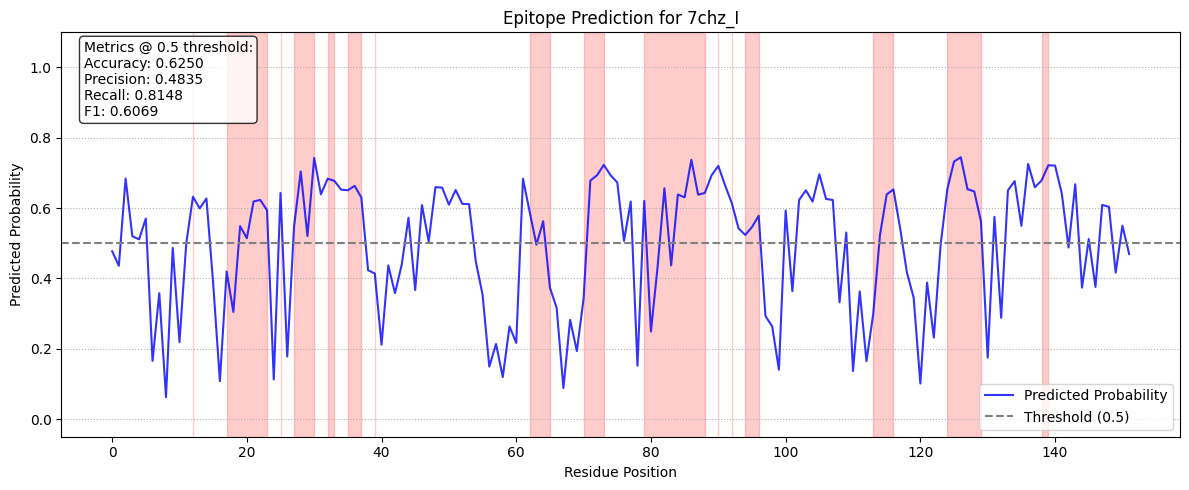

-------------------------------------------------

--- Visualization for Protein: 6hga_B ---
Length (visualized): 263
Performance Metrics: F1 = 0.0645, Accuracy = 0.8897
True Epitopes (12 residues):
lpwlnvsadgdnvhlvlnvseeqhfglslywnqvqgppkprwhknltgpqiitlqhtdlv
pclciqvwplepdsvrtnicpfredprahqnlwqaarlrlltlqswlldapcslpaeaal
cwrapggdpcqplvpplsweqvtvdkvlefpllkghpnlcvqvqsseklqlqeclwadsl
gplkddvllletrgpqdqrslcalepsgctslpsKaStraaRLgEYllqdlqsgqclqlw
dddlgalwacpmdkyihKREFRH

Predicted Epitopes (19 residues @ 0.5 threshold):
lpwlnvsadgdnvhlvlnvseeqhfGlslywnqvqgPpKpRWhknltgpqiitlqhtdlv
pclciqvwplePdsvrtnicpfredprahqnlwqaarlrlltlqswlldapcslpaEaal
cwrapggDpcqplVpplsweqvtvdkvlefpllkghpnlcvqvQssEklqlqeclwadsl
gplkddvllletrgpqdqrslcalEPSgctslPskastRaaRlgeyllqdlqsgqclqlw
dDdlgalwacpMdkyihkrefrh


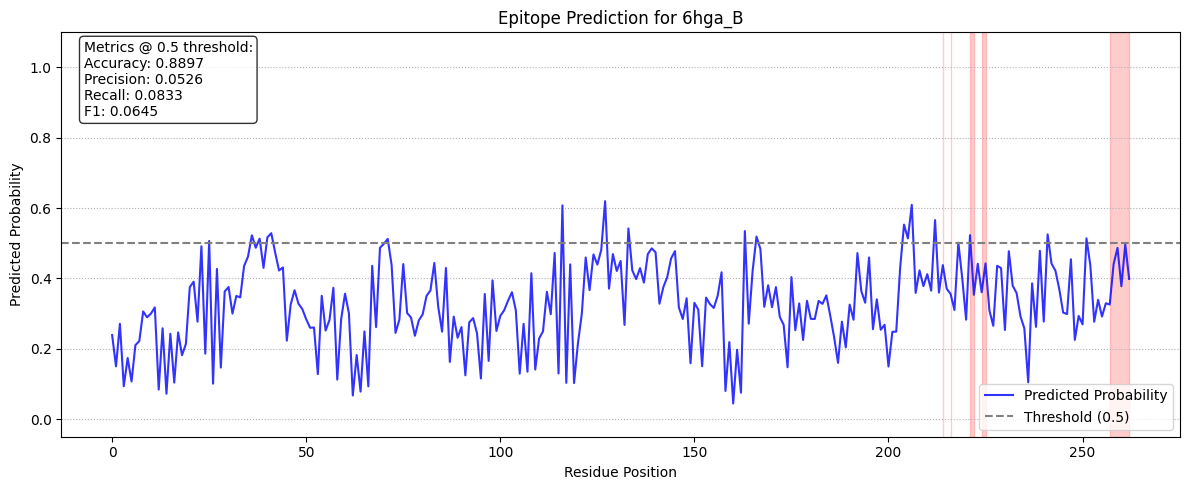

-------------------------------------------------


In [81]:
if 'protein_results' in locals() and isinstance(ensemble_metrics, dict):
    VISUALIZATION_THRESHOLD = 0.5
    
    # Best and worst performers based on your data
    PROTEINS_TO_VISUALIZE = ['7chz_I', '6hga_B']  # Best and worst 
    
    if not PROTEINS_TO_VISUALIZE:
         print("No proteins selected for visualization.")
    else:
        print(f"\nGenerating visualizations for: {PROTEINS_TO_VISUALIZE}")
        # Ensure H5_TEST_PATH is defined from previous cells
        if 'H5_TEST_PATH' not in locals() or not H5_TEST_PATH:
             print("Error: H5_TEST_PATH variable not defined. Cannot load sequences.")
        else:
            for protein_id in PROTEINS_TO_VISUALIZE:
                if protein_id in ensemble_metrics:
                    sequence = load_sequence_from_h5(H5_TEST_PATH, protein_id)
                    true_labels = ensemble_metrics[protein_id]['labels']
                    predicted_probs = ensemble_metrics[protein_id]['probabilities']
                    visualize_protein_predictions_standalone(
                        protein_id, sequence, true_labels, predicted_probs, threshold=VISUALIZATION_THRESHOLD
                    )
                else:
                    print(f"Protein ID '{protein_id}' not found in collected results.")
else:
    print("Variable 'protein_results' not found or is not a dictionary. Make sure the evaluation cell ran successfully.")


--- Visualizing ROC and PR Curves ---


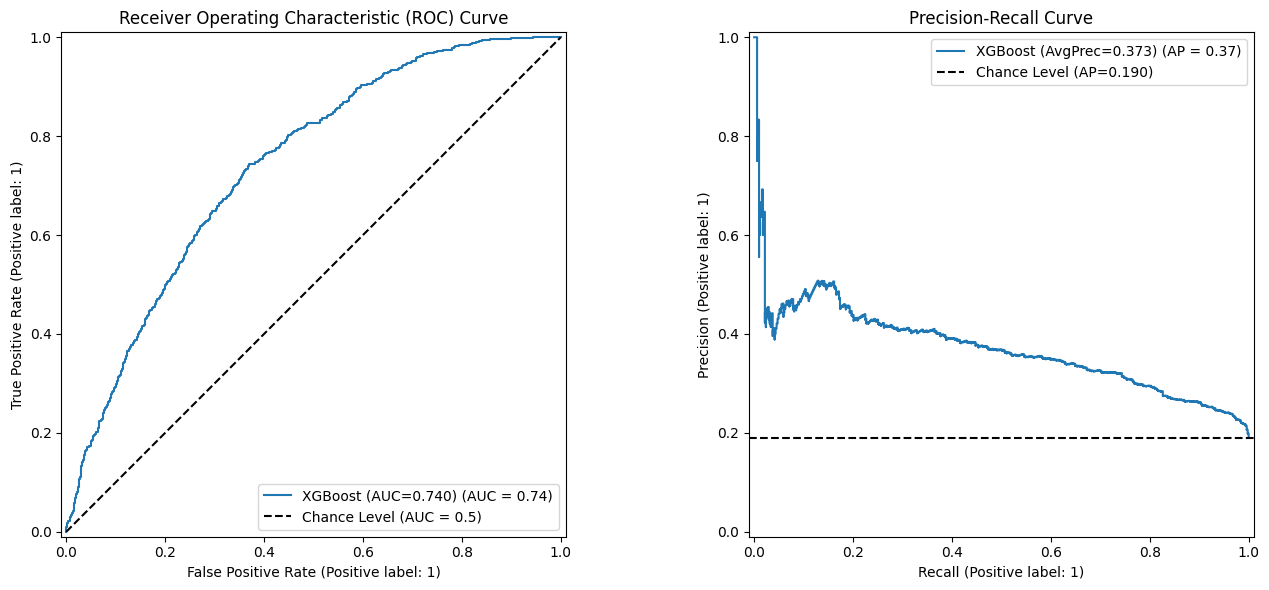

In [82]:
# --- Visualize ROC and Precision-Recall Curves ---
print("\n--- Visualizing ROC and PR Curves ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob_test, ax=ax1, name=f'XGBoost (AUC={test_auc_roc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_pred_prob_test, ax=ax2, name=f'XGBoost (AvgPrec={test_auc_pr:.3f})')
# Calculate chance level for PR curve (proportion of positive samples)
chance_level_pr = test_results['num_pos_test'] / test_results['num_test_samples']
ax2.axhline(chance_level_pr, color='k', linestyle='--', label=f'Chance Level (AP={chance_level_pr:.3f})')
ax2.set_title('Precision-Recall Curve')
ax2.legend()


plt.tight_layout()
plt.show()

Correlation between protein length and F1 score: -0.2055
Regression slope: -0.000349
P-value: 0.462532
R-squared: 0.0422


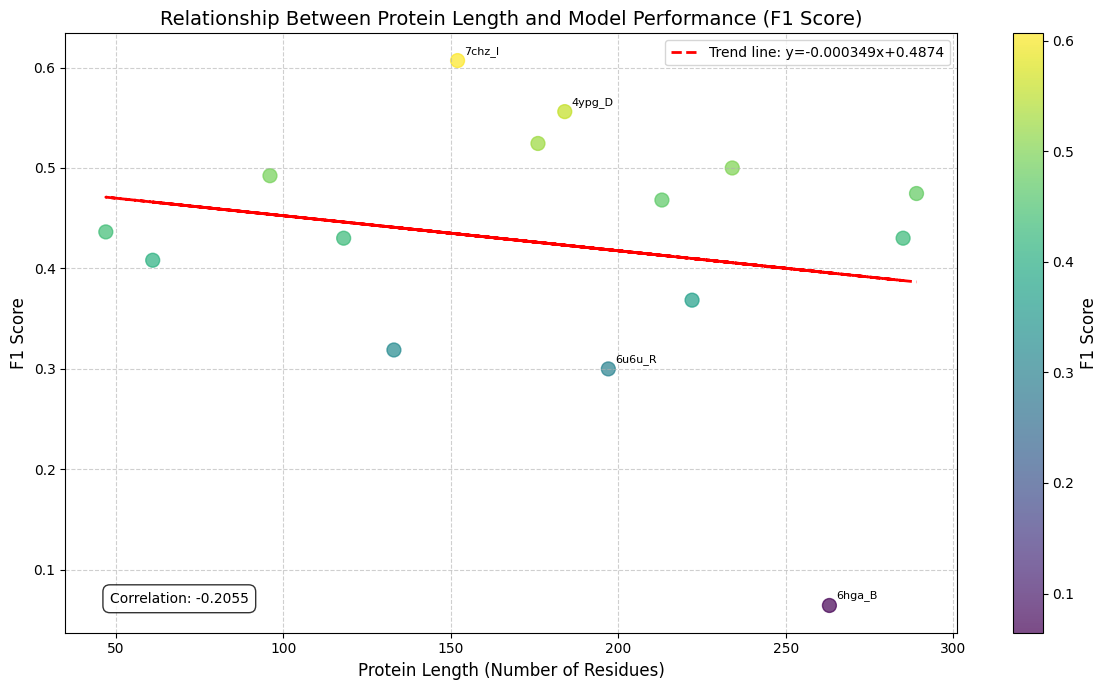

In [83]:
def plot_protein_length_vs_f1(ensemble_metrics, mlp_protein_data):
    # Extract protein lengths and F1 scores
    protein_data = []
    
    for protein_id, metrics in ensemble_metrics.items():
        # Get protein length from the mlp_protein_data dictionary
        if protein_id in mlp_protein_data:
            protein_length = len(mlp_protein_data[protein_id]['labels'])
            f1_score = metrics['f1']
            
            # Only include if F1 score is valid (not NaN)
            if not np.isnan(f1_score):
                protein_data.append({
                    'protein_id': protein_id,
                    'length': protein_length,
                    'f1_score': f1_score
                })
    
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(protein_data)
    
    # Create the scatter plot
    plt.figure(figsize=(12, 7))
    scatter = plt.scatter(df['length'], df['f1_score'], alpha=0.7, 
                          c=df['f1_score'], cmap='viridis', s=100)
    
    # Add a trend line
    z = np.polyfit(df['length'], df['f1_score'], 1)
    p = np.poly1d(z)
    plt.plot(df['length'], p(df['length']), "r--", 
             linewidth=2, label=f"Trend line: y={z[0]:.6f}x+{z[1]:.4f}")
    
    # Calculate correlation coefficient
    correlation = np.corrcoef(df['length'], df['f1_score'])[0,1]
    
    # Add labels and title
    plt.xlabel('Protein Length (Number of Residues)', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('Relationship Between Protein Length and Model Performance (F1 Score)', 
              fontsize=14)
    
    # Add a color bar to show F1 score scale
    cbar = plt.colorbar(scatter)
    cbar.set_label('F1 Score', fontsize=12)
    
    # Add annotation for correlation
    plt.annotate(f"Correlation: {correlation:.4f}", 
                 xy=(0.05, 0.05), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
    
    # Add protein IDs as labels for data points of interest
    # Show protein IDs for points with very high or very low F1 scores
    threshold_high = df['f1_score'].quantile(0.9)  # Top 10%
    threshold_low = df['f1_score'].quantile(0.1)   # Bottom 10%
    
    for i, row in df.iterrows():
        if row['f1_score'] >= threshold_high or row['f1_score'] <= threshold_low:
            plt.annotate(row['protein_id'], 
                        (row['length'], row['f1_score']),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=8)
    
    # Add legend
    plt.legend(loc='best')
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig('protein_length_vs_f1.png', dpi=300)
    plt.savefig('protein_length_vs_f1.pdf')
    
    # Show statistics
    print(f"Correlation between protein length and F1 score: {correlation:.4f}")
    
    # Optional: add regression statistics
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['length'], df['f1_score'])
    print(f"Regression slope: {slope:.6f}")
    print(f"P-value: {p_value:.6f}")
    print(f"R-squared: {r_value**2:.4f}")
    
    plt.show()
    
    # Return the dataframe for further analysis
    return df

# Example usage:
df = plot_protein_length_vs_f1(ensemble_metrics, mlp_stuff)


Analyzing amino acid performance across all proteins in the test set...
Processed 10 proteins...
Analysis complete. Processed 15 proteins. Skipped 0 proteins due to missing sequences or errors.


/tmp/ipykernel_610814/2240996982.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Amino Acid', y='F1 Score', data=results_df, ax=axes[0], palette=colors)



Summary of Model Performance by Amino Acid Property:
- Average F1 Score: 0.426
- Hydrophobic (core) amino acids F1: 0.384
- Hydrophilic (surface) amino acids F1: 0.469
- Correlation between Epitope % and F1: 0.830
- Performance difference (surface vs. core): 0.085 F1 points
  → Model performs better on surface-exposed amino acids


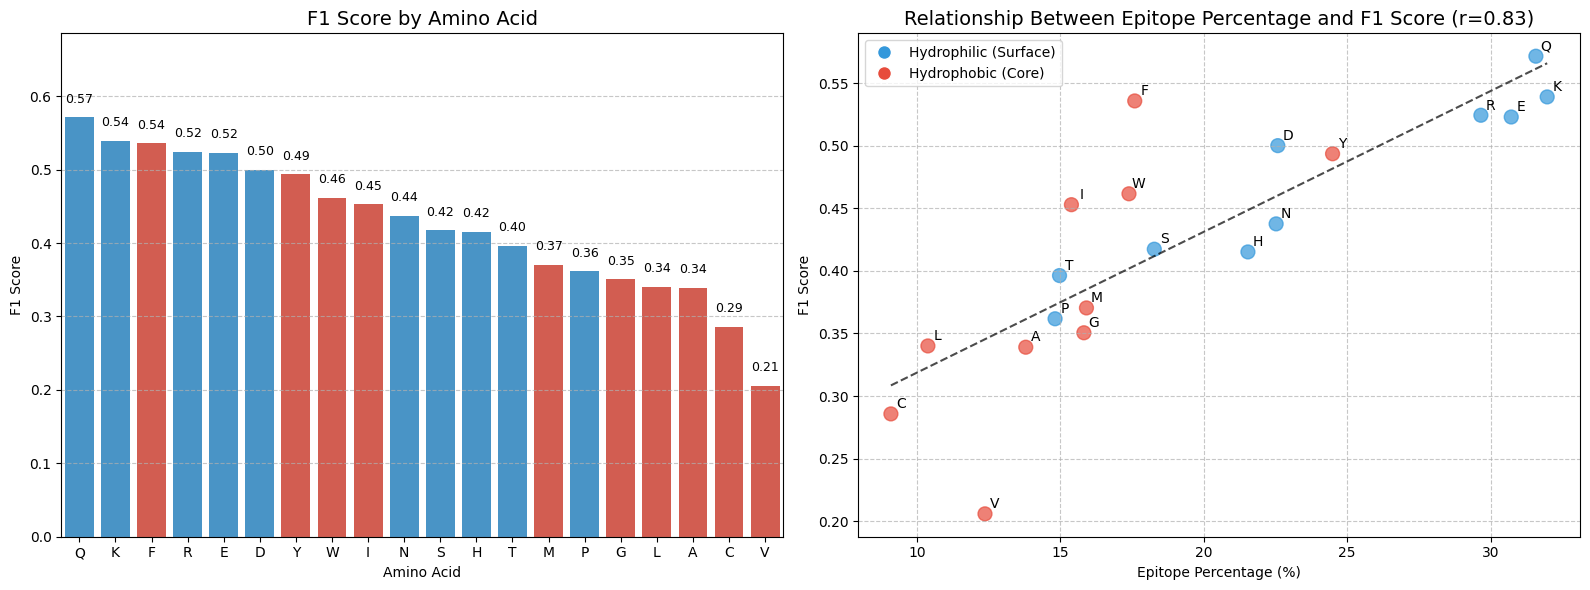

In [84]:
def analyze_amino_acid_performance_complete(protein_results, h5_test_path):
    
    # Standard amino acids
    amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
                   'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    
    # Define hydrophobic amino acids for coloring
    hydrophobic = ['A', 'C', 'F', 'I', 'L', 'M', 'V', 'W', 'Y', 'G']
    
    # Initialize data collection for each amino acid
    aa_metrics = {aa: {
        'total_count': 0,
        'epitope_count': 0,
        'true_positives': 0,
        'false_positives': 0,
        'true_negatives': 0,
        'false_negatives': 0
    } for aa in amino_acids}
    
    # Process each protein in the test set
    proteins_processed = 0
    proteins_skipped = 0
    
    print(f"Analyzing amino acid performance across all proteins in the test set...")
    for protein_id in protein_results:
        # Load sequence from HDF5 file
        sequence = load_sequence_from_h5(h5_test_path, protein_id)
        
        # Skip if sequence couldn't be loaded
        if sequence is None:
            proteins_skipped += 1
            continue
            
        # Get prediction data
        true_labels = protein_results[protein_id]['labels']
        predicted_probs = protein_results[protein_id]['probabilities']
        predicted_labels = (predicted_probs >= 0.5).astype(int)
        
        # Ensure all arrays have the same length
        min_len = min(len(sequence), len(true_labels), len(predicted_labels))
        if min_len == 0:
            proteins_skipped += 1
            continue
            
        # Adjust lengths if needed
        sequence = sequence[:min_len]
        true_labels = true_labels[:min_len]
        predicted_labels = predicted_labels[:min_len]
        
        # Process each amino acid in the sequence
        for i in range(min_len):
            aa = sequence[i].upper()
            
            # Skip non-standard amino acids
            if aa not in amino_acids:
                continue
                
            # Update counts
            aa_metrics[aa]['total_count'] += 1
            if true_labels[i] == 1:
                aa_metrics[aa]['epitope_count'] += 1
                
            # Update confusion matrix
            if true_labels[i] == 1 and predicted_labels[i] == 1:
                aa_metrics[aa]['true_positives'] += 1
            elif true_labels[i] == 0 and predicted_labels[i] == 1:
                aa_metrics[aa]['false_positives'] += 1
            elif true_labels[i] == 0 and predicted_labels[i] == 0:
                aa_metrics[aa]['true_negatives'] += 1
            elif true_labels[i] == 1 and predicted_labels[i] == 0:
                aa_metrics[aa]['false_negatives'] += 1
        
        proteins_processed += 1
        
        # Print progress every 10 proteins
        if proteins_processed % 10 == 0:
            print(f"Processed {proteins_processed} proteins...")
    
    print(f"Analysis complete. Processed {proteins_processed} proteins. Skipped {proteins_skipped} proteins due to missing sequences or errors.")
    
    # Calculate metrics for each amino acid
    results = []
    
    for aa in amino_acids:
        # Skip amino acids with too few occurrences
        if aa_metrics[aa]['total_count'] < 20:
            continue
            
        # Calculate epitope percentage
        epitope_pct = (aa_metrics[aa]['epitope_count'] / aa_metrics[aa]['total_count'] * 100 
                      if aa_metrics[aa]['total_count'] > 0 else 0)
        
        # Calculate performance metrics
        tp = aa_metrics[aa]['true_positives']
        fp = aa_metrics[aa]['false_positives']
        tn = aa_metrics[aa]['true_negatives']
        fn = aa_metrics[aa]['false_negatives']
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Store results
        results.append({
            'Amino Acid': aa,
            'Hydrophobic': aa in hydrophobic,
            'Total Count': aa_metrics[aa]['total_count'],
            'Epitope Count': aa_metrics[aa]['epitope_count'],
            'Epitope Percentage': epitope_pct,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn
        })
    
    # Convert to DataFrame and sort by F1 score
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('F1 Score', ascending=False)
    
    # Create visualizations with only 2 plots (F1 by AA and Epitope % vs F1)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Define colors based on hydrophobicity
    colors = ['#3498db' if not row['Hydrophobic'] else '#e74c3c' for _, row in results_df.iterrows()]
    
    # 1. F1 Score by Amino Acid
    sns.barplot(x='Amino Acid', y='F1 Score', data=results_df, ax=axes[0], palette=colors)
    axes[0].set_title('F1 Score by Amino Acid', fontsize=14)
    axes[0].set_ylim(0, min(1, results_df['F1 Score'].max() * 1.2))
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    for i, v in enumerate(results_df['F1 Score']):
        axes[0].text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=9)
    
    # 2. Scatter plot of Epitope Percentage vs F1 Score
    scatter = axes[1].scatter(
        results_df['Epitope Percentage'], 
        results_df['F1 Score'],
        c=colors, s=100, alpha=0.7
    )
    
    # Add amino acid labels to each point
    for i, aa in enumerate(results_df['Amino Acid']):
        axes[1].annotate(
            aa, 
            (results_df['Epitope Percentage'].iloc[i], results_df['F1 Score'].iloc[i]),
            fontsize=10, ha='center', va='center',
            xytext=(7, 7), textcoords='offset points'
        )
    
    # Add trend line
    z = np.polyfit(results_df['Epitope Percentage'], results_df['F1 Score'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(results_df['Epitope Percentage'].min(), results_df['Epitope Percentage'].max(), 100)
    axes[1].plot(x_trend, p(x_trend), "k--", alpha=0.7)
    
    # Calculate correlation
    correlation = np.corrcoef(results_df['Epitope Percentage'], results_df['F1 Score'])[0,1]
    
    axes[1].set_xlabel('Epitope Percentage (%)')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title(f'Relationship Between Epitope Percentage and F1 Score (r={correlation:.2f})', fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    # Add legend for hydrophobic vs hydrophilic
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', markersize=10, label='Hydrophilic (Surface)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=10, label='Hydrophobic (Core)')
    ]
    axes[1].legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.savefig('amino_acid_performance.png', dpi=300)
    plt.savefig('amino_acid_performance.pdf')
    
    # Print summary statistics
    print("\nSummary of Model Performance by Amino Acid Property:")
    
    hydrophobic_f1 = results_df[results_df['Hydrophobic']]['F1 Score'].mean()
    hydrophilic_f1 = results_df[~results_df['Hydrophobic']]['F1 Score'].mean()
    
    print(f"- Average F1 Score: {results_df['F1 Score'].mean():.3f}")
    print(f"- Hydrophobic (core) amino acids F1: {hydrophobic_f1:.3f}")
    print(f"- Hydrophilic (surface) amino acids F1: {hydrophilic_f1:.3f}")
    print(f"- Correlation between Epitope % and F1: {correlation:.3f}")
    
    # Additional business insight: Calculate performance difference
    perf_diff = hydrophilic_f1 - hydrophobic_f1
    print(f"- Performance difference (surface vs. core): {perf_diff:.3f} F1 points")
    if perf_diff > 0:
        print("  → Model performs better on surface-exposed amino acids")
    else:
        print("  → Model performs better on core amino acids")
    
    return results_df, fig


results_df, fig = analyze_amino_acid_performance_complete(
     protein_results=protein_results,  # Your ensemble results dictionary
     h5_test_path=H5_TEST_PATH         # Path to your HDF5 file with sequences
 )

In [86]:
results_df.sort_values("F1 Score")

,Amino Acid,Hydrophobic,Total Count,Epitope Count,Epitope Percentage,Precision,Recall,F1 Score,TP,FP,TN,FN
17,V,True,194,24,12.371134,0.159091,0.291667,0.205882,7,37,133,17
1,C,True,77,7,9.090909,0.214286,0.428571,0.285714,3,11,59,4
0,A,True,145,20,13.793103,0.256410,0.500000,0.338983,10,29,96,10
9,L,True,289,30,10.380623,0.242857,0.566667,0.340000,17,53,206,13
5,G,True,177,28,15.819209,0.246377,0.607143,0.350515,17,52,97,11
12,P,False,135,20,14.814815,0.229730,0.850000,0.361702,17,57,58,3
10,M,True,44,7,15.909091,0.250000,0.714286,0.370370,5,15,22,2
16,T,False,167,25,14.970060,0.259259,0.840000,0.396226,21,60,82,4
6,H,False,65,14,21.538462,0.282051,0.785714,0.415094,11,28,23,3
15,S,False,197,36,18.274112,0.281553,0.805556,0.417266,29,74,87,7


# Compare Versus Bepipred

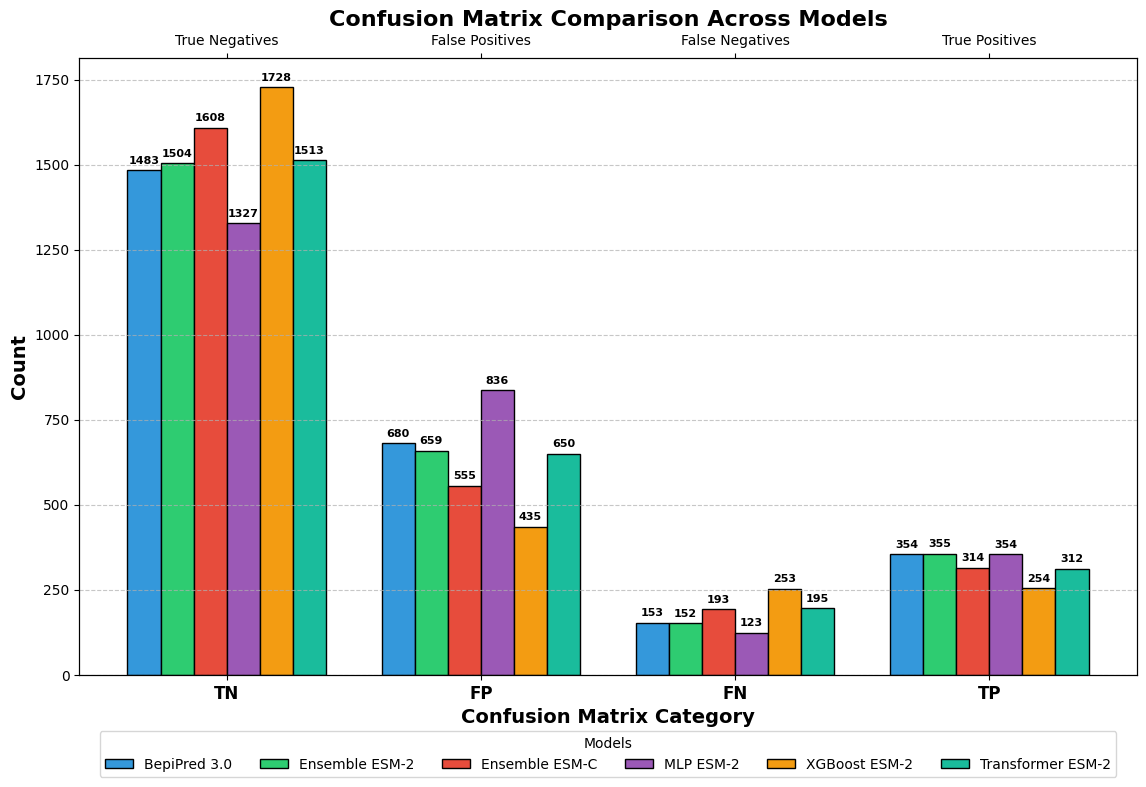

In [12]:
models = ['BepiPred 3.0', 'Ensemble ESM-2', 'Ensemble ESM-C', 'MLP ESM-2', 'XGBoost ESM-2', 'Transformer ESM-2']

# Confusion matrix components [TN, FP, FN, TP]
bepipred_data = [1483, 680, 153, 354]
mlp_esm2_data = [1327, 836, 123, 354]
#mlp_esmc_data = [1628, 535, 212, 295]  
xgb_esm2 = [1728, 435, 253, 254]
transformer_esm2 = [1513, 650, 195, 312]
ensemble_method = [1504, 659, 152, 355]
ensemble_esmc = [1608, 555, 193, 314]

# Combine data
data = np.array([bepipred_data, ensemble_method, ensemble_esmc, mlp_esm2_data, xgb_esm2, transformer_esm2])

# Labels for each category
categories = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
category_short = ['TN', 'FP', 'FN', 'TP']

# Set up the figure with a larger size for better readability
fig, ax = plt.subplots(figsize=(12, 8))

# Set width of bars
barWidth = 0.13
num_models = len(models)
total_bar_width = barWidth * num_models

# Calculate positions for each group
positions = np.arange(len(categories))

# Colors for each model
colors = ['#3498db', '#2ecc71', '#e74c3c', "#9b59b6", "#f39c12", "#1abc9c"]

# Create bars manually
bars = []
for i in range(len(models)):
    # Calculate the offset to center the group of bars
    # For 5 bars, positions would be: -2*width, -width, 0, +width, +2*width
    offset = barWidth * (i - (num_models-1)/2)
    bar = ax.bar(positions + offset, data[i], width=barWidth, 
           color=colors[i], edgecolor='black', linewidth=1)
    bars.append(bar)

# Add counts as text labels on top of each bar
for i in range(len(models)):
    offset = barWidth * (i - (num_models-1)/2)
    for j in range(len(categories)):
        ax.text(positions[j] + offset, data[i][j] + 20, 
               str(data[i][j]), ha='center', fontsize=8, fontweight='bold')

# Add labels, title and custom x-axis tick labels
ax.set_xlabel('Confusion Matrix Category', fontsize=14, fontweight='bold')
ax.set_ylabel('Count', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix Comparison Across Models', fontsize=16, fontweight='bold')
ax.set_xticks(positions)  # Set ticks at the exact positions
ax.set_xticklabels(category_short, fontsize=12, fontweight='bold')

# Add a second x-axis with full category names
ax2 = ax.twiny()
ax2.set_xticks(positions)  # Set ticks at the exact positions
ax2.set_xticklabels(categories, fontsize=10)
ax2.set_xlim(ax.get_xlim())

# Add the legend with appropriate positioning
ax.legend([b[0] for b in bars], models, title="Models", 
          loc='upper center', bbox_to_anchor=(0.5, -0.08),
          ncol=len(models), fontsize=10)

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout with space for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend at the bottom

plt.show()

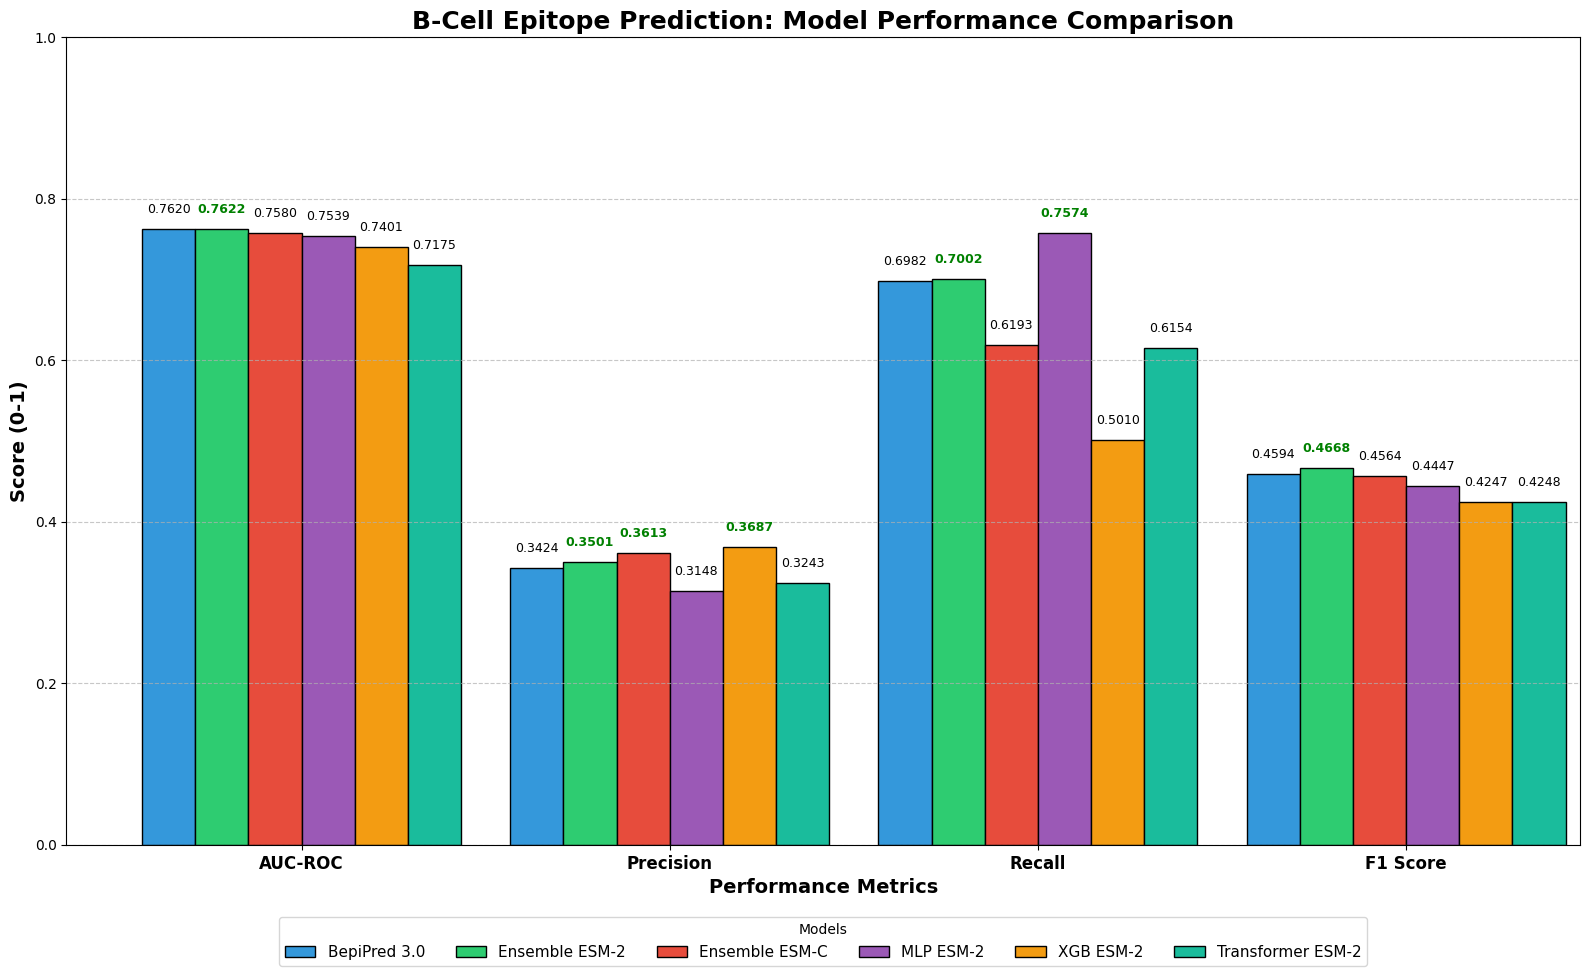

In [11]:

# Data for each model
models = ['BepiPred 3.0', 'Ensemble ESM-2', 'Ensemble ESM-C', 'MLP ESM-2', 'XGB ESM-2', 'Transformer ESM-2']

# AUC-roc values for each model
auc_roc_values = {
    'BepiPred 3.0': 0.762,
    'Ensemble ESM-2': 0.762233,
    'Ensemble ESM-C': 0.757986, 
    'MLP ESM-2': 0.7539,
    'XGB ESM-2': 0.7401,
    'Transformer ESM-2': 0.7175
}

# Confusion matrix components [TN, FP, FN, TP]
bepipred = [1483, 680, 153, 354]
ensemble_esmc = [1608, 555, 193, 314]
ensemble_method = [1504, 659, 152, 355]
mlp_esm2 = [1327, 836, 123, 384]
xgb_esm2 = [1728, 435, 253, 254]
transformer_esm2 = [1513, 650, 195, 312]

# Calculate metrics for each model
def calculate_metrics(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return [precision, recall, f1]

# Calculate metrics (excluding accuracy)
bepipred_metrics = calculate_metrics(bepipred)
mlp_esm2_metrics = calculate_metrics(mlp_esm2)
xgb_esm2_metrics = calculate_metrics(xgb_esm2)
transformer_esm2_met = calculate_metrics(transformer_esm2)
ensemble_metrics = calculate_metrics(ensemble_method)
ensemble_esm2 = calculate_metrics(ensemble_esmc)

# Create AUC-PR array
auc_pr_array = np.array([[auc_roc_values[model]] for model in models])

# Combine AUC-PR with other metrics
metrics_data = np.hstack((auc_pr_array, np.array([bepipred_metrics, ensemble_metrics, ensemble_esm2, mlp_esm2_metrics, 
                         xgb_esm2_metrics, transformer_esm2_met])))

# Metric names including AUC-PR
metric_names = ['AUC-ROC', 'Precision', 'Recall', 'F1 Score']

# Set up the figure
fig, ax = plt.subplots(figsize=(16, 10))

# Define group spacing
group_width = 1.0  # Width of each group of bars
group_gap = 0.8    # Gap between groups
barWidth = 0.26   # Width of individual bars (reduced size to fit all 6 models)

# Create positions for each group with spacing between groups
group_positions = np.arange(len(metric_names)) * (group_width + group_gap)

# Colors for each model
colors = ['#3498db', '#2ecc71', '#e74c3c', "#9b59b6", "#f39c12", "#1abc9c"]

# Create bars for all models
bars = []
for i in range(len(models)):
    # Position each bar within its group
    bar_pos = group_positions + (i * barWidth)
    
    # Create the bar
    bar = ax.bar(bar_pos, metrics_data[i], width=barWidth, 
                color=colors[i], edgecolor='black', linewidth=1)
    bars.append(bar)

# Add metric values as text labels on top of each bar
for i in range(len(models)):
    for j in range(len(metric_names)):
        val = metrics_data[i][j]
        
        # For BepiPred, keep regular text
        if models[i] == 'BepiPred 3.0':
            ax.text(group_positions[j] + (i * barWidth), val + 0.02, 
                    f'{val:.4f}', ha='center', fontsize=9)
        else:
            # For other models, check if they outperform BepiPred
            if val > metrics_data[0][j]:
                text_color = 'green'
                fontweight = 'bold'
            else:
                text_color = 'black'
                fontweight = 'normal'
                
            ax.text(group_positions[j] + (i * barWidth), val + 0.02, 
                    f'{val:.4f}', ha='center', fontsize=9, 
                    fontweight=fontweight, color=text_color)

# Add labels and title
ax.set_xlabel('Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylabel('Score (0-1)', fontsize=14, fontweight='bold')
ax.set_title('B-Cell Epitope Prediction: Model Performance Comparison', fontsize=18, fontweight='bold')

# Set x-ticks at the center of each group
ax.set_xticks(group_positions + (barWidth * len(models) / 2) - (barWidth/2))
ax.set_xticklabels(metric_names, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1.0)  # Set y-axis limits

# Add the legend with all models
ax.legend([b[0] for b in bars], models, title="Models", 
          loc='upper center', bbox_to_anchor=(0.5, -0.08),
          ncol=6, fontsize=11)

# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust plot to fit all groups with spacing
ax.set_xlim(-0.5, group_positions[-1] + group_width + 0.5)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend at the bottom

plt.show()